<a href="https://colab.research.google.com/github/ryukir11/Tugas-Akhir/blob/main/JPN_RIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade yfinance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from tensorflow.keras.optimizers import Adam
import math
import plotly.express as px
import plotly.figure_factory as ff
import yfinance as yf
import statsmodels.api as sm
from statistics import mode
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis
import plotly.graph_objects as go
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
data = yf.download('^N225', start='2000-01-04', end='2024-05-01')

scaler = MinMaxScaler()
def scaling_data(data):
    features = [features for features in data.columns]
    data[features] = scaler.fit_transform(data[features])
    return data

data = scaling_data(data)
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open    Volume
Ticker         ^N225     ^N225     ^N225     ^N225     ^N225
Date                                                        
2000-01-04  0.353138  0.355631  0.354176  0.350549  0.000000
2000-01-05  0.339533  0.350215  0.332953  0.352498  0.000000
2000-01-06  0.328470  0.337834  0.331365  0.339822  0.000000
2000-01-07  0.329214  0.329095  0.328394  0.328609  0.000000
2000-01-11  0.348647  0.346803  0.333673  0.330145  0.000000
...              ...       ...       ...       ...       ...
2024-04-23  0.901391  0.903788  0.901633  0.907157  0.161122
2024-04-24  0.928226  0.922686  0.915281  0.909366  0.203461
2024-04-25  0.903647  0.912960  0.907770  0.915091  0.191364
2024-04-26  0.912700  0.912019  0.906183  0.905048  0.209845
2024-04-30  0.926618  0.927043  0.924908  0.922374  0.254368

[5960 rows x 5 columns]

In [ ]:
data2 = yf.download('^N225', start='2000-01-04', end='2024-04-30')
mini = data2['Close'].min()
max = data2['Close'].max()
price_range = max-mini
range_value = price_range.iloc[0]
range_value

[*********************100%***********************]  1 of 1 completed


np.float64(33833.44970703125)

In [ ]:
ret_df = data['Close']
def windowed_df(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][-1]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

In [ ]:
X, y, dates = windowed_df(ret_df, 5)

In [ ]:
data['Date'] = pd.to_datetime(data.index)

data.set_index('Date', inplace=True)

all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

data_full = data.reindex(all_dates)

data_full = data_full.interpolate(method='linear')

data_full = data_full.reset_index()
data_full.rename(columns={'index': 'Date'}, inplace=True)
data_full = data_full[:8883]
df = data_full.copy()
print(data_full)

Price        Date     Close      High       Low      Open    Volume
Ticker                ^N225     ^N225     ^N225     ^N225     ^N225
0      2000-01-04  0.353138  0.355631  0.354176  0.350549  0.000000
1      2000-01-05  0.339533  0.350215  0.332953  0.352498  0.000000
2      2000-01-06  0.328470  0.337834  0.331365  0.339822  0.000000
3      2000-01-07  0.329214  0.329095  0.328394  0.328609  0.000000
4      2000-01-08  0.334072  0.333522  0.329714  0.328993  0.000000
...           ...       ...       ...       ...       ...       ...
8878   2024-04-25  0.903647  0.912960  0.907770  0.915091  0.191364
8879   2024-04-26  0.912700  0.912019  0.906183  0.905048  0.209845
8880   2024-04-27  0.916179  0.915775  0.910864  0.909379  0.220976
8881   2024-04-28  0.919659  0.919531  0.915546  0.913711  0.232107
8882   2024-04-29  0.923138  0.923287  0.920227  0.918042  0.243238

[8883 rows x 6 columns]


In [ ]:
def calculate_forward_trend_duration1(prices):
    n = len(prices)
    durations = [1] * n
    for i in range(n-1):
        count = 0
        j = i + 1

        if prices[j] > prices[i]:
            trend = "up"
        elif prices[j] < prices[i]:
            trend = "down"
        else:
            trend = "none"

        while j < n:
            if trend == "up" and prices[j] > prices[j - 1]:
                count += 1
            elif trend == "down" and prices[j] < prices[j - 1]:
                count += 1
            else:
                break
            j += 1

        durations[i] = count
    return durations

data_full['Trend_Duration'] = calculate_forward_trend_duration1(data_full['Close'].values)
print(data_full)

Price        Date     Close      High       Low      Open    Volume  \
Ticker                ^N225     ^N225     ^N225     ^N225     ^N225   
0      2000-01-04  0.353138  0.355631  0.354176  0.350549  0.000000   
1      2000-01-05  0.339533  0.350215  0.332953  0.352498  0.000000   
2      2000-01-06  0.328470  0.337834  0.331365  0.339822  0.000000   
3      2000-01-07  0.329214  0.329095  0.328394  0.328609  0.000000   
4      2000-01-08  0.334072  0.333522  0.329714  0.328993  0.000000   
...           ...       ...       ...       ...       ...       ...   
8878   2024-04-25  0.903647  0.912960  0.907770  0.915091  0.191364   
8879   2024-04-26  0.912700  0.912019  0.906183  0.905048  0.209845   
8880   2024-04-27  0.916179  0.915775  0.910864  0.909379  0.220976   
8881   2024-04-28  0.919659  0.919531  0.915546  0.913711  0.232107   
8882   2024-04-29  0.923138  0.923287  0.920227  0.918042  0.243238   

Price  Trend_Duration  
Ticker                 
0                   2  
1   

## LSTM MODEL

In [ ]:
data_full.index = data_full['Date']
data_full

Price            Date     Close      High       Low      Open    Volume  \
Ticker                    ^N225     ^N225     ^N225     ^N225     ^N225   
Date                                                                      
2000-01-04 2000-01-04  0.353138  0.355631  0.354176  0.350549  0.000000   
2000-01-05 2000-01-05  0.339533  0.350215  0.332953  0.352498  0.000000   
2000-01-06 2000-01-06  0.328470  0.337834  0.331365  0.339822  0.000000   
2000-01-07 2000-01-07  0.329214  0.329095  0.328394  0.328609  0.000000   
2000-01-08 2000-01-08  0.334072  0.333522  0.329714  0.328993  0.000000   
...               ...       ...       ...       ...       ...       ...   
2024-04-25 2024-04-25  0.903647  0.912960  0.907770  0.915091  0.191364   
2024-04-26 2024-04-26  0.912700  0.912019  0.906183  0.905048  0.209845   
2024-04-27 2024-04-27  0.916179  0.915775  0.910864  0.909379  0.220976   
2024-04-28 2024-04-28  0.919659  0.919531  0.915546  0.913711  0.232107   
2024-04-29 2024-04-29  0.923138  0.923287  0.920227  0.918042  0.243238   

Price      Trend_Duration  
Ticker                     
Date                       
2000-01-04              2  
2000-01-05              1  
2000-01-06              5  
2000-01-07              4  
2000-01-08              3  
...                   ...  
2024-04-25              4  
2024-04-26              3  
2024-04-27              2  
2024-04-28              1  
2024-04-29              1  

[8883 rows x 7 columns]

In [ ]:
#Sliding Window
X_close, y_close, dates_close = windowed_df(data_full['Close'], 5)
n_total = len(X_close)
Mq_80 = int(n_total*0.8)
Mq_90 = int(n_total*0.9)
dates_train, X_train, y_train = dates_close[:Mq_80], X_close[:Mq_80], y_close[:Mq_80]
dates_val, X_val, y_val = dates_close[Mq_80:Mq_90], X_close[Mq_80:Mq_90], y_close[Mq_80:Mq_90]
dates_test, X_test, y_test = dates_close[Mq_90:], X_close[Mq_90:], y_close[Mq_90:]

In [ ]:
data_full.iloc[7101:7106]

Price            Date     Close      High       Low      Open    Volume  \
Ticker                    ^N225     ^N225     ^N225     ^N225     ^N225   
Date                                                                      
2019-06-14 2019-06-14  0.415622  0.412480  0.414490  0.412879  0.101478   
2019-06-15 2019-06-15  0.415692  0.413123  0.415216  0.413328  0.095150   
2019-06-16 2019-06-16  0.415762  0.413766  0.415942  0.413776  0.088822   
2019-06-17 2019-06-17  0.415832  0.414408  0.416668  0.414224  0.082493   
2019-06-18 2019-06-18  0.411360  0.413478  0.413096  0.414720  0.091734   

Price      Trend_Duration  
Ticker                     
Date                       
2019-06-14              3  
2019-06-15              2  
2019-06-16              1  
2019-06-17              1  
2019-06-18              2

In [ ]:
X_train[7101]

array([[0.41562155],
       [0.41569159],
       [0.41576163],
       [0.41583167],
       [0.41136009]])

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
print(np.min(y_train))  # Harusnya > 0 kalau mau MAPE aman
print(np.sum(y_train == 0))

0.0
1


In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(64, activation = 'relu', return_sequences = True, input_shape = (5,1)),
    layers.Dropout(0.2),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

## CLOSE

In [ ]:
result = []
train_pred = []
val_pred = []
test_pred = []
histories = []
train_mapes = []
val_mapes = []
test_mapes = []

for i in range(30):
    print(f"\nTraining iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    checkpoint_path = f'best_weights_iter_{i+1}.weights.h5'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_train, y_train,
        batch_size=128,
        validation_data=(X_val, y_val),
        epochs=50,
        callbacks=[checkpoint],
        verbose=0
    )

    result.append(history)
    histories.append(history.history)

    model.load_weights(checkpoint_path)

    train = model.predict(X_train, verbose=0).flatten()
    val = model.predict(X_val, verbose=0).flatten()
    test = model.predict(X_test, verbose=0).flatten()

    train_pred.append(train)
    val_pred.append(val)
    test_pred.append(test)

    mape_train = mean_absolute_percentage_error(y_train, train)
    mape_val = mean_absolute_percentage_error(y_val, val)
    mape_test = mean_absolute_percentage_error(y_test, test)

    train_mapes.append(mape_train)
    val_mapes.append(mape_val)
    test_mapes.append(mape_test)

    print(f"Iteration {i+1} - MAPE Train: {mape_train:.4f}, Val: {mape_val:.4f}, Test: {mape_test:.4f}")


Training iteration 1...
Iteration 1 - MAPE Train: 19115504454.6500, Val: 0.0539, Test: 0.0844

Training iteration 2...
Iteration 2 - MAPE Train: 16663365037.4521, Val: 0.0626, Test: 0.1018

Training iteration 3...
Iteration 3 - MAPE Train: 18855709194.0173, Val: 0.0289, Test: 0.0290

Training iteration 4...
Iteration 4 - MAPE Train: 18725631436.5924, Val: 0.0368, Test: 0.0482

Training iteration 5...
Iteration 5 - MAPE Train: 18784728483.0689, Val: 0.0452, Test: 0.0667

Training iteration 6...
Iteration 6 - MAPE Train: 17222667384.8933, Val: 0.0422, Test: 0.0556

Training iteration 7...
Iteration 7 - MAPE Train: 19243521085.4924, Val: 0.0392, Test: 0.0430

Training iteration 8...
Iteration 8 - MAPE Train: 15007552799.5667, Val: 0.0462, Test: 0.0725

Training iteration 9...
Iteration 9 - MAPE Train: 16745700252.5807, Val: 0.0439, Test: 0.0665

Training iteration 10...
Iteration 10 - MAPE Train: 17997421833.0763, Val: 0.0276, Test: 0.0284

Training iteration 11...
Iteration 11 - MAPE Tr

In [ ]:
best_index = np.argmin(val_mapes)
print(f"\nBest iteration: {best_index+1}")
print(f"Val MAPE: {val_mapes[best_index]:.4f}, Test MAPE: {test_mapes[best_index]:.4f}")


Best iteration: 30
Val MAPE: 0.0218, Test MAPE: 0.0233


In [ ]:
model.load_weights(f'best_weights_iter_{best_index+1}.weights.h5')

In [ ]:
train_df = pd.DataFrame(train_pred).transpose()
val_df = pd.DataFrame(val_pred).transpose()
test_df = pd.DataFrame(test_pred).transpose()

train_df.columns = [f'Iterasi {i+1}' for i in range(train_df.shape[1])]
val_df.columns = [f'Iterasi {i+1}' for i in range(val_df.shape[1])]
test_df.columns = [f'Iterasi {i+1}' for i in range(test_df.shape[1])]

train_df['Rata2'] = train_df.mean(axis=1)
val_df['Rata2'] = val_df.mean(axis=1)
test_df['Rata2'] = test_df.mean(axis=1)

train_df.index = dates_train
val_df.index = dates_val
test_df.index = dates_test

In [ ]:
train_df = train_df.multiply(range_value)
train_df.to_csv('hasiltrainlstm_JPN.csv')
train_df

Iterasi 1     Iterasi 2     Iterasi 3     Iterasi 4  \
2000-01-09  11423.384766  11327.222656  11462.582031  11570.599609   
2000-01-10  11211.708984  11107.468750  11248.761719  11356.194336   
2000-01-11  11163.238281  11046.441406  11187.666016  11297.976562   
2000-01-12  11281.059570  11157.553711  11303.572266  11414.621094   
2000-01-13  11421.624023  11296.598633  11443.965820  11556.860352   
...                  ...           ...           ...           ...   
2019-06-15  13953.676758  13820.272461  13935.384766  13999.314453   
2019-06-16  13949.478516  13815.568359  13932.260742  13993.970703   
2019-06-17  13922.759766  13781.472656  13899.708984  13964.950195   
2019-06-18  13916.342773  13771.763672  13890.096680  13957.514648   
2019-06-19  13931.031250  13792.911133  13908.717773  13974.189453   

               Iterasi 5     Iterasi 6     Iterasi 7     Iterasi 8  \
2000-01-09  11425.504883  11395.849609  11406.458984  11414.741211   
2000-01-10  11213.020508  11179.404297  11176.785156  11219.098633   
2000-01-11  11164.855469  11125.107422  11109.501953  11180.775391   
2000-01-12  11282.713867  11241.423828  11221.893555  11302.004883   
2000-01-13  11423.013672  11383.323242  11365.088867  11438.548828   
...                  ...           ...           ...           ...   
2019-06-15  13980.945312  13945.712891  13918.292969  13959.594727   
2019-06-16  13977.571289  13942.336914  13915.947266  13953.785156   
2019-06-17  13947.925781  13910.083008  13885.066406  13923.242188   
2019-06-18  13937.489258  13898.800781  13873.356445  13916.291016   
2019-06-19  13955.785156  13919.470703  13893.527344  13933.117188   

               Iterasi 9    Iterasi 10  ...    Iterasi 22    Iterasi 23  \
2000-01-09  11422.667969  11516.038086  ...  11407.334961  11448.056641   
2000-01-10  11218.951172  11283.597656  ...  11188.414062  11222.387695   
2000-01-11  11172.216797  11220.164062  ...  11134.977539  11164.324219   
2000-01-12  11286.537109  11337.839844  ...  11254.366211  11283.314453   
2000-01-13  11423.632812  11483.555664  ...  11398.605469  11429.180664   
...                  ...           ...  ...           ...           ...   
2019-06-15  13987.577148  14013.042969  ...  13998.380859  13961.191406   
2019-06-16  13982.719727  14011.665039  ...  13992.633789  13957.208008   
2019-06-17  13947.146484  13978.838867  ...  13960.831055  13926.577148   
2019-06-18  13937.851562  13965.877930  ...  13952.259766  13917.618164   
2019-06-19  13958.566406  13988.204102  ...  13971.518555  13936.017578   

              Iterasi 24    Iterasi 25    Iterasi 26    Iterasi 27  \
2000-01-09  11384.301758  11430.162109  11344.109375  11469.519531   
2000-01-10  11187.399414  11217.704102  11134.532227  11246.976562   
2000-01-11  11150.564453  11168.340820  11090.460938  11189.970703   
2000-01-12  11271.234375  11288.244141  11212.887695  11307.388672   
2000-01-13  11408.190430  11431.722656  11356.220703  11451.273438   
...                  ...           ...           ...           ...   
2019-06-15  13957.490234  14053.145508  13902.054688  13984.166992   
2019-06-16  13951.864258  14046.966797  13897.714844  13982.757812   
2019-06-17  13922.552734  14017.424805  13867.386719  13950.876953   
2019-06-18  13916.952148  14009.689453  13858.707031  13940.356445   
2019-06-19  13932.127930  14027.598633  13876.354492  13959.859375   

              Iterasi 28    Iterasi 29    Iterasi 30         Rata2  
2000-01-09  11395.530273  11536.536133  11455.554688  11444.553711  
2000-01-10  11195.206055  11311.644531  11242.359375  11227.530273  
2000-01-11  11153.757812  11255.955078  11192.030273  11173.248047  
2000-01-12  11278.657227  11377.908203  11313.522461  11291.297852  
2000-01-13  11425.444336  11524.194336  11458.250000  11434.160156  
...                  ...           ...           ...           ...  
2019-06-15  13973.870117  13944.088867  13968.348633  13966.264648  
2019-06-16  13967.870117  13941.205078 

In [ ]:
print(np.min(train_df))

711.6461181640625


In [ ]:
val_df = val_df.multiply(range_value)
val_df.to_csv('hasilvallstm_JPN.csv')
val_df

Iterasi 1     Iterasi 2     Iterasi 3     Iterasi 4  \
2019-06-20  13937.122070  13797.272461  13915.437500  13979.874023   
2019-06-21  13964.941406  13821.208984  13938.849609  14008.049805   
2019-06-22  14000.958008  13856.610352  13967.385742  14046.992188   
2019-06-23  14039.263672  13901.371094  14006.608398  14088.268555   
2019-06-24  14131.163086  14020.707031  14121.912109  14191.212891   
...                  ...           ...           ...           ...   
2021-11-19  20651.779297  20239.287109  22226.078125  21479.500000   
2021-11-20  20650.400391  20238.347656  22225.082031  21478.906250   
2021-11-21  20635.298828  20224.451172  22204.289062  21461.289062   
2021-11-22  20613.156250  20203.216797  22172.593750  21433.802734   
2021-11-23  20625.642578  20214.087891  22188.505859  21447.019531   

               Iterasi 5     Iterasi 6     Iterasi 7     Iterasi 8  \
2019-06-20  13962.177734  13925.648438  13899.135742  13939.000000   
2019-06-21  13991.927734  13953.913086  13922.468750  13968.785156   
2019-06-22  14029.839844  13988.161133  13956.472656  14007.004883   
2019-06-23  14063.616211  14023.388672  13989.474609  14053.768555   
2019-06-24  14172.619141  14137.222656  14105.673828  14157.782227   
...                  ...           ...           ...           ...   
2021-11-19  21052.017578  21305.345703  21601.861328  20912.605469   
2021-11-20  21050.974609  21304.224609  21601.837891  20910.505859   
2021-11-21  21035.511719  21288.011719  21583.414062  20896.412109   
2021-11-22  21012.779297  21263.347656  21553.326172  20876.625000   
2021-11-23  21025.970703  21276.931641  21566.857422  20889.787109   

               Iterasi 9    Iterasi 10  ...    Iterasi 22    Iterasi 23  \
2019-06-20  13965.144531  13992.500977  ...  13977.281250  13941.488281   
2019-06-21  13990.127930  14015.785156  ...  14001.279297  13966.725586   
2019-06-22  14022.062500  14045.184570  ...  14036.945312  14000.908203   
2019-06-23  14070.336914  14077.215820  ...  14082.025391  14039.649414   
2019-06-24  14192.490234  14196.255859  ...  14192.794922  14147.828125   
...                  ...           ...  ...           ...           ...   
2021-11-19  21056.125000  22197.597656  ...  19820.873047  21257.931641   
2021-11-20  21055.587891  22196.687500  ...  19819.548828  21256.416016   
2021-11-21  21040.289062  22175.546875  ...  19807.509766  21238.845703   
2021-11-22  21016.339844  22143.179688  ...  19790.013672  21213.056641   
2021-11-23  21028.273438  22158.607422  ...  19800.642578  21226.894531   

              Iterasi 24    Iterasi 25    Iterasi 26    Iterasi 27  \
2019-06-20  13938.679688  14032.305664  13882.858398  13966.159180   
2019-06-21  13971.641602  14059.221680  13908.432617  13988.800781   
2019-06-22  14011.692383  14095.004883  13943.813477  14017.903320   
2019-06-23  14057.369141  14139.278320  13984.539062  14052.017578   
2019-06-24  14155.798828  14243.250977  14091.317383  14163.700195   
...                  ...           ...           ...           ...   
2021-11-19  20766.500000  20406.328125  20455.660156  21060.132812   
2021-11-20  20765.414062  20405.580078  20453.308594  21059.046875   
2021-11-21  20750.814453  20391.929688  20439.103516  21043.216797   
2021-11-22  20728.259766  20370.509766  20420.402344  21019.400391   
2021-11-23  20740.226562  20381.578125  20433.492188  21032.677734   

              Iterasi 28    Iterasi 29    Iterasi 30         Rata2  
2019-06-20  13955.168945  13927.154297  13948.913086  13946.239258  
2019-06-21  13985.414062  13957.348633  13977.915039  13972.502930  
2019-06-22  14027.240234  13990.393555  14015.353516  14006.739258  
2019-06-23  14071.608398  14026.311523  14061.764648  14047.206055  
2019-06-24  14172.968750  14128.509766  14166.361328  14157.913086  
...                  ...           ...           ...           ...  
2021-11-19  20432.056641  22585.386719  22553.984375  21150.888672  
2021-11-20  20430.818359  22582.740234 

In [ ]:
test_df = test_df.multiply(range_value)
test_df.to_csv('hasiltestlstm_JPN.csv')
test_df

Iterasi 1     Iterasi 2     Iterasi 3     Iterasi 4  \
2021-11-24  20652.355469  20239.935547  22226.957031  21480.386719   
2021-11-25  20616.531250  20207.380859  22180.865234  21442.582031   
2021-11-26  20565.621094  20160.505859  22113.423828  21386.230469   
2021-11-27  20456.417969  20060.146484  21968.363281  21265.748047   
2021-11-28  20285.921875  19902.251953  21740.375000  21073.425781   
...                  ...           ...           ...           ...   
2024-04-25  27437.744141  26602.998047  31732.544922  29138.931641   
2024-04-26  27597.300781  26753.529297  31963.376953  29319.376953   
2024-04-27  27754.306641  26902.916016  32193.773438  29498.964844   
2024-04-28  27904.876953  27045.583984  32418.369141  29674.404297   
2024-04-29  28049.449219  27189.474609  32638.181641  29847.601562   

               Iterasi 5     Iterasi 6     Iterasi 7     Iterasi 8  \
2021-11-24  21052.416016  21306.023438  21602.943359  20913.000000   
2021-11-25  21012.869141  21264.804688  21562.578125  20872.443359   
2021-11-26  20959.876953  21208.427734  21503.345703  20819.599609   
2021-11-27  20841.281250  21085.083984  21374.951172  20703.988281   
2021-11-28  20659.496094  20892.710938  21169.798828  20528.507812   
...                  ...           ...           ...           ...   
2024-04-25  28280.195312  28921.632812  30012.046875  27855.837891   
2024-04-26  28449.242188  29097.035156  30211.746094  28015.875000   
2024-04-27  28616.853516  29270.515625  30417.167969  28170.816406   
2024-04-28  28777.517578  29438.179688  30614.531250  28319.363281   
2024-04-29  28934.669922  29593.537109  30808.357422  28461.416016   

               Iterasi 9    Iterasi 10  ...    Iterasi 22    Iterasi 23  \
2021-11-24  21056.812500  22198.613281  ...  19821.304688  21258.650391   
2021-11-25  21020.232422  22156.109375  ...  19789.691406  21220.197266   
2021-11-26  20968.796875  22090.300781  ...  19746.964844  21162.990234   
2021-11-27  20856.169922  21951.833984  ...  19654.011719  21042.441406   
2021-11-28  20680.041016  21730.371094  ...  19510.521484  20851.947266   
...                  ...           ...  ...           ...           ...   
2024-04-25  28150.150391  31500.705078  ...  25447.810547  28943.533203   
2024-04-26  28318.708984  31732.417969  ...  25577.085938  29128.273438   
2024-04-27  28486.037109  31963.140625  ...  25704.599609  29309.500000   
2024-04-28  28647.414062  32188.691406  ...  25826.052734  29483.921875   
2024-04-29  28803.626953  32407.500000  ...  25942.023438  29653.113281   

              Iterasi 24    Iterasi 25    Iterasi 26    Iterasi 27  \
2021-11-24  20767.236328  20407.044922  20455.902344  21060.716797   
2021-11-25  20730.373047  20373.228516  20419.496094  21020.695312   
2021-11-26  20679.166016  20326.097656  20369.761719  20966.068359   
2021-11-27  20567.525391  20223.855469  20262.882812  20846.013672   
2021-11-28  20393.728516  20062.632812  20100.406250  20660.404297   
...                  ...           ...           ...           ...   
2024-04-25  27622.054688  26733.472656  26865.384766  28543.275391   
2024-04-26  27781.992188  26878.990234  27015.156250  28717.269531   
2024-04-27  27940.271484  27022.601562  27159.847656  28890.503906   
2024-04-28  28092.472656  27162.240234  27292.228516  29059.128906   
2024-04-29  28239.308594  27302.781250  27423.050781  29222.511719   

              Iterasi 28    Iterasi 29    Iterasi 30         Rata2  
2021-11-24  20432.505859  22586.130859  22554.978516  21151.582031  
2021-11-25  20397.351562  22532.302734  22504.312500  21112.511719  
2021-11-26  20350.394531  22459.378906  22435.431641  21057.326172  
2021-11-27  20247.121094  22302.373047  22286.943359  20938.085938  
2021-11-28  20088.593750  22060.261719  22054.822266  20751.648438  
...                  ...           ...           ...           ...  
2024-04-25  26723.781250  32579.593750  31831.103516  28652.687500  
2024-04-26  26868.876953  32821.167969 

In [ ]:
traincopy = train_df.copy()
valcopy = val_df.copy()
testcopy = test_df.copy()

## IMPORT

In [ ]:
traincopy = pd.read_csv('hasiltrainlstm_JP.csv')
valcopy = pd.read_csv('hasilvallstm_JP.csv')
testcopy = pd.read_csv('hasiltestlstm_JP.csv')

In [ ]:
traincopy.index = traincopy['Unnamed: 0']
valcopy.index = valcopy['Unnamed: 0']
testcopy.index = testcopy['Unnamed: 0']

In [ ]:
traincopy = traincopy.drop(columns=['Unnamed: 0'])
valcopy = valcopy.drop(columns=['Unnamed: 0'])
testcopy = testcopy.drop(columns=['Unnamed: 0'])

In [ ]:
train_df = traincopy.copy()
val_df = valcopy.copy()
test_df = testcopy.copy()

## MAPE

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
y_test2 = y_test*range_value
y_train2 = y_train*range_value
y_val2 = y_val*range_value
print(y_train2)

[11467.18505859 11631.5625     11795.93994141 ... 14069.02001953
 13917.73095703 14278.88916016]


In [ ]:
y_train2 = y_train*range_value

In [ ]:
from math import sqrt
prediction = testcopy['Rata2']
close_test_mae = mean_absolute_error(y_test2, prediction)
close_test_mse = mean_squared_error(y_test2, prediction)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, prediction)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

(1435.3700015396278,
 2365753.316356923,
 1538.1005546962535,
 0.06169778428775499)

In [ ]:
val_result = valcopy['Rata2']
close_val_mae = mean_absolute_error(y_val2, val_result)
close_val_mse = mean_squared_error(y_val2, val_result)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val2, val_result)
close_val_mae, close_val_mse, close_val_rmse, close_val_mape

(841.5346066769911, 1078677.1813420642, 1038.593848114875, 0.04427430124481639)

In [ ]:
train_result = traincopy['Rata2']
y_train2[y_train == 0] = mini
close_train_mae = mean_absolute_error(y_train2, train_result)
close_train_mse = mean_squared_error(y_train2, train_result)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train2, train_result)
close_train_mae, close_train_mse, close_train_rmse, close_train_mape

(218.4443364293726, 86369.05780904305, 293.8861306850717, 0.06584600244699022)

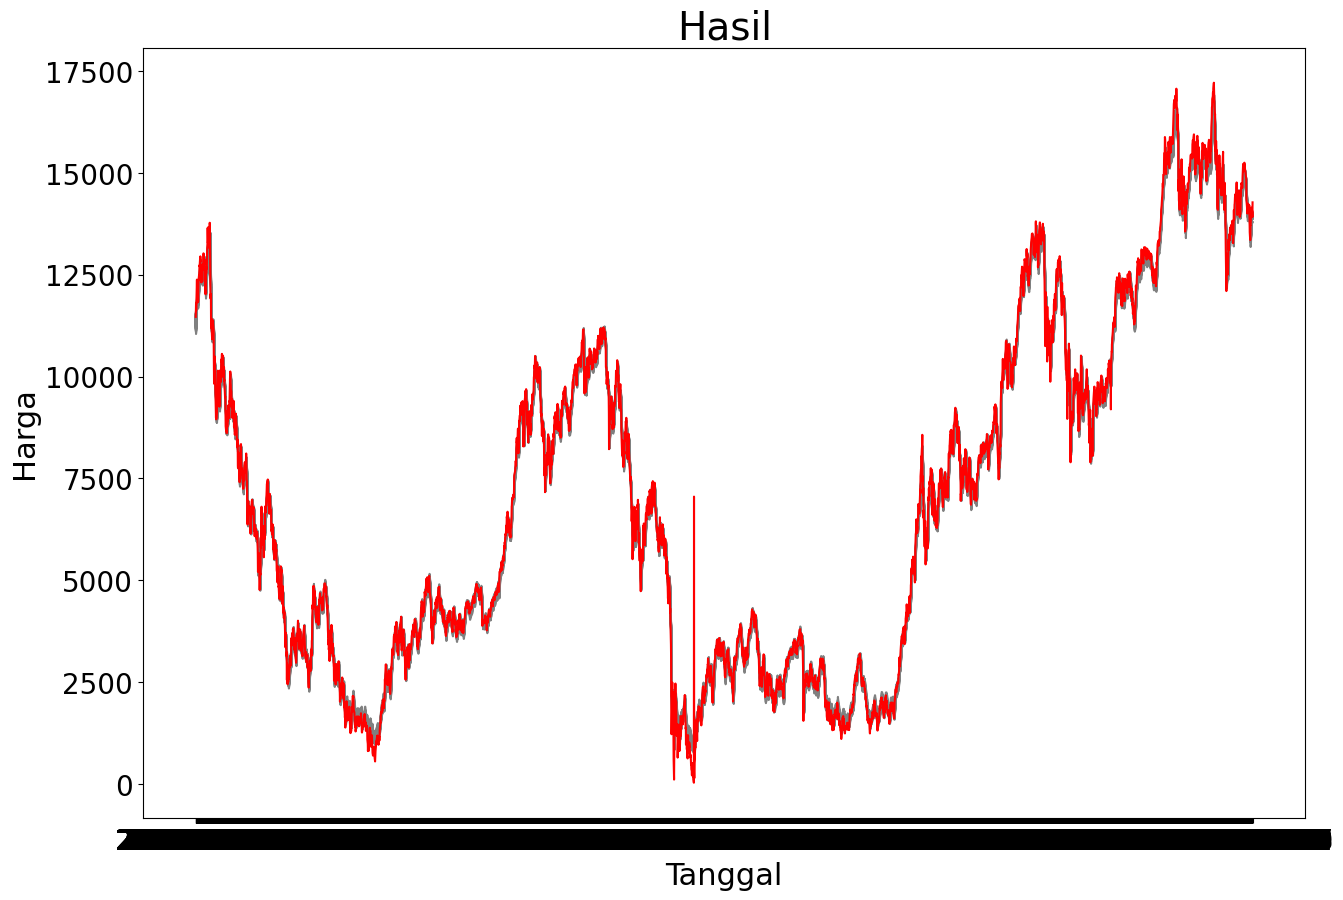

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in traincopy.columns:
  if column != 'Rata2':
    ax.plot(traincopy.index, traincopy[column], label='Prediksi', color='gray')
ax.plot(traincopy.index, y_train2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

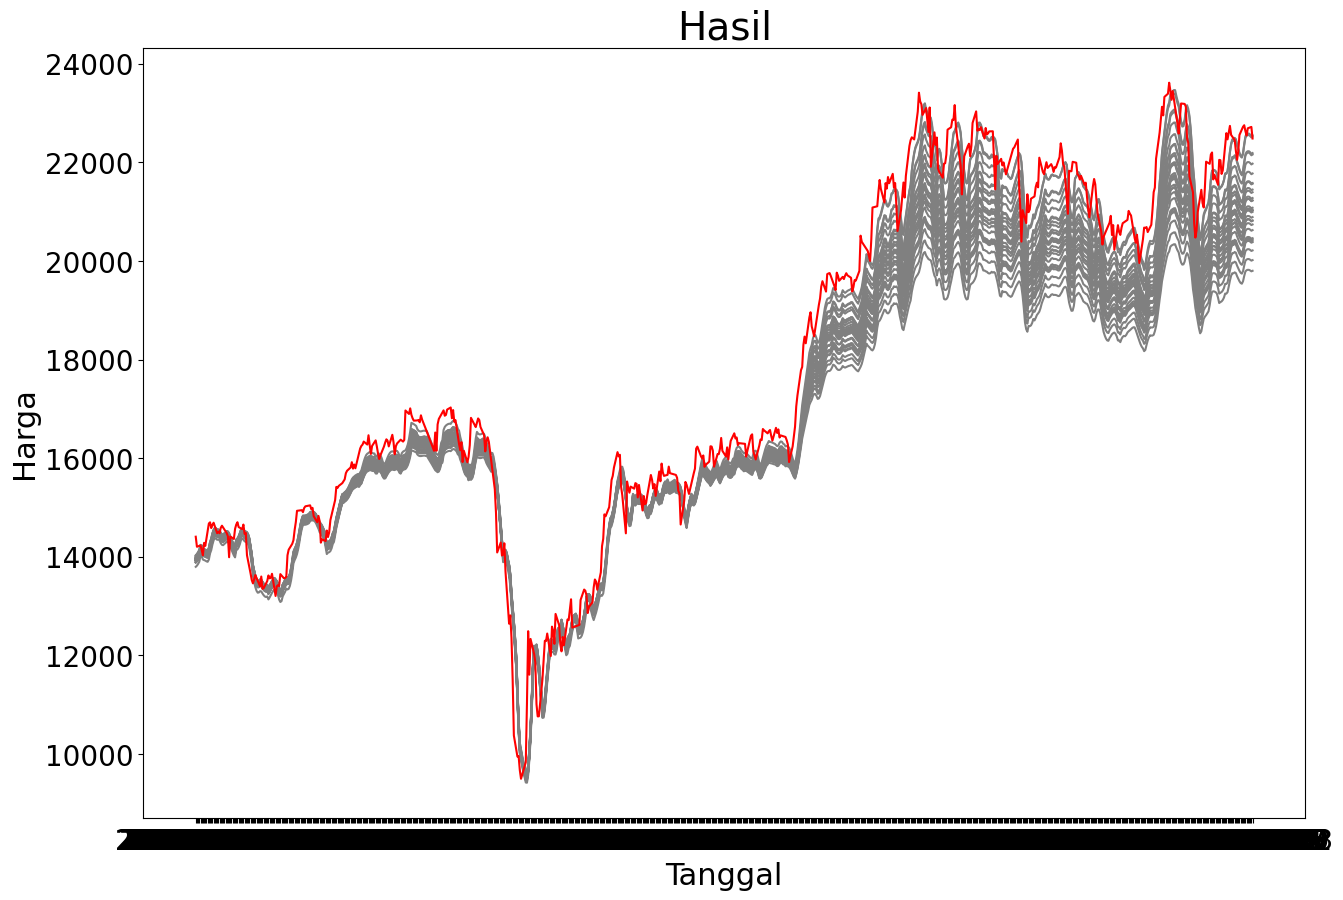

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in val_df.columns:
  if column != 'Rata2':
    ax.plot(val_df.index, val_df[column], label='Prediksi', color='gray')
ax.plot(val_df.index, y_val2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

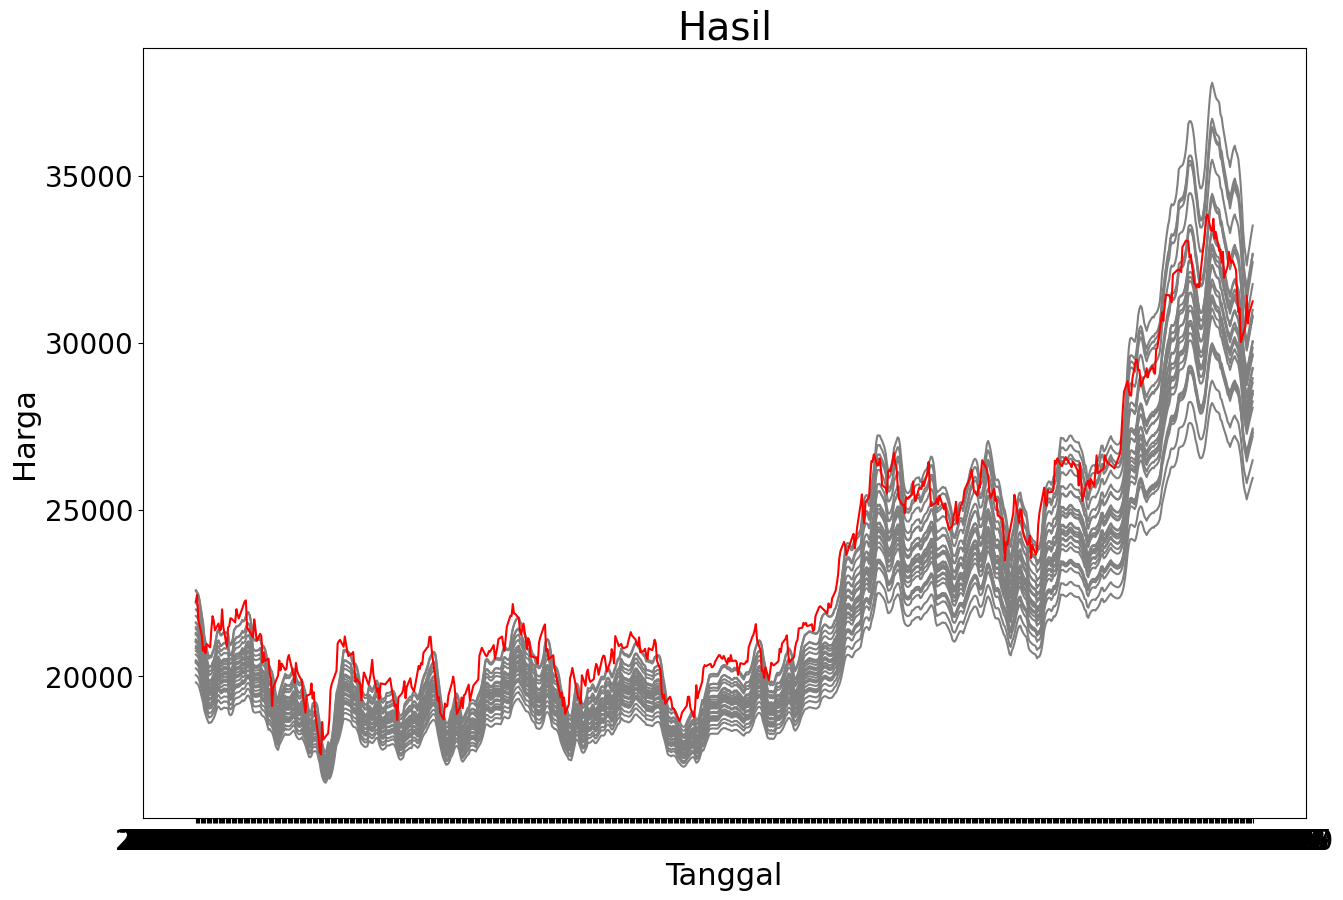

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in test_df.columns:
  if column != 'Rata2':
    ax.plot(test_df.index, test_df[column], label='Prediksi', color='gray')
ax.plot(test_df.index, y_test2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## Model Hybrid

In [ ]:
traincnn = train_df['Rata2']
valcnn = val_df['Rata2']
testcnn = test_df['Rata2']

traincnn = pd.DataFrame(traincnn)
valcnn = pd.DataFrame(valcnn)
testcnn = pd.DataFrame(testcnn)

traincnn.columns = ['Close']
valcnn.columns = ['Close']
testcnn.columns = ['Close']

traincnn = traincnn.divide(range_value)
valcnn = valcnn.divide(range_value)
testcnn = testcnn.divide(range_value)
traincnn.shape, valcnn.shape, testcnn.shape, df.shape

((7102, 1), (888, 1), (888, 1), (8883, 6))

In [ ]:
padding = traincnn[:2]
df = pd.concat([padding, traincnn, valcnn, testcnn])
df.reset_index(drop=True, inplace=True)
df

Close
0     0.338262
1     0.331847
2     0.338262
3     0.331847
4     0.330243
...        ...
8875  0.846875
8876  0.852114
8877  0.857299
8878  0.862299
8879  0.867145

[8880 rows x 1 columns]

In [ ]:
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_200']= df['Close'].ewm(span=200, adjust=False).mean()
df['Diff'] = df['EMA_50']-df['EMA_200']
df['sign'] = df['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
df['sign_change'] = df['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = df[df['sign_change']==1]

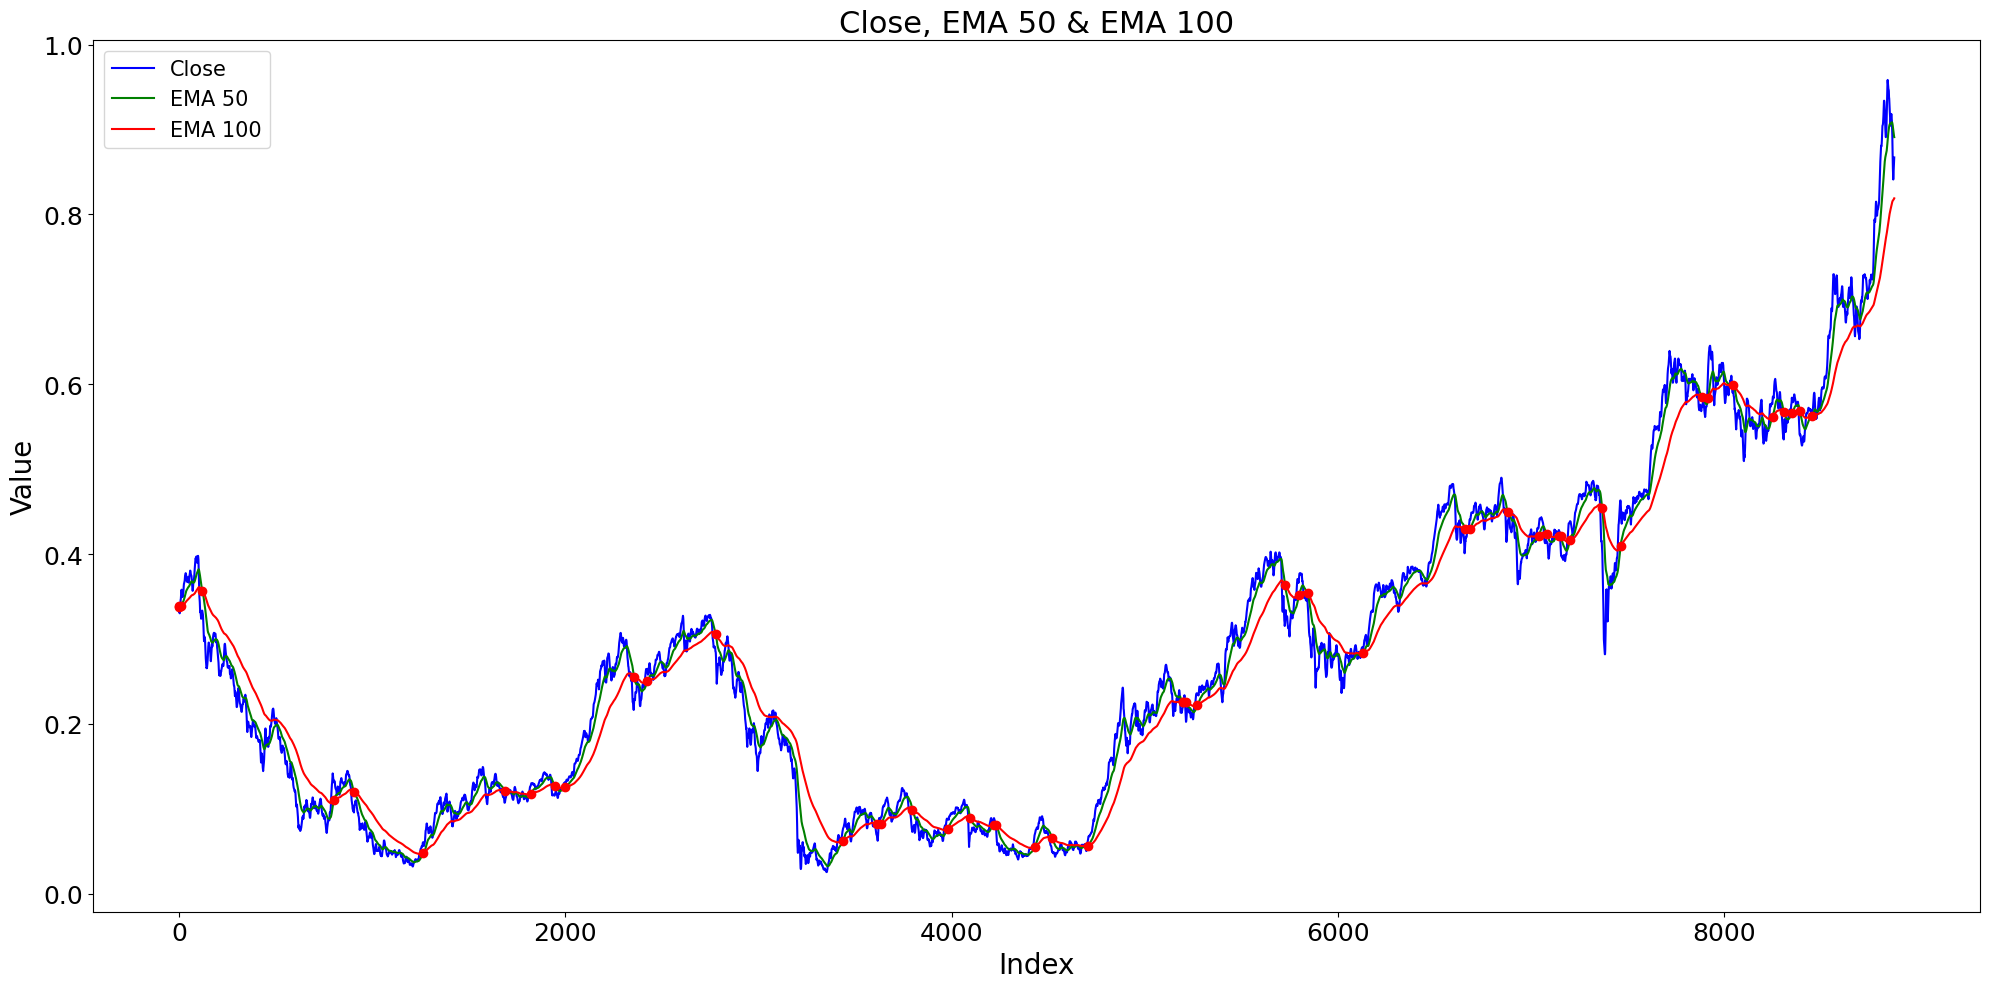

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(df['Close'], label='Close', color='blue')
plt.plot(df['EMA_50'], label='EMA50', color='green')
plt.plot(df['EMA_200'], label='EMA200', color='red')
plt.plot(idx1.index, df.loc[idx1.index, 'EMA_200'], 'ro', label='Sign Change')
plt.legend(['Close','EMA 50','EMA 100'], fontsize=15)
plt.title('Close, EMA 50 & EMA 100', fontsize=22)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

## Data Buy Keep Sell


In [ ]:
df['label'] = df.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
df_buy_sell = df[df['label'] != 'Keep']
df_buy_sell

Close    EMA_50   EMA_200      Diff  sign  sign_change label
1     0.331847  0.338010  0.338198 -0.000188    -1            1   Buy
10    0.347367  0.338478  0.338281  0.000197     1            1  Sell
122   0.331836  0.356512  0.356610 -0.000098    -1            1   Buy
804   0.132735  0.111075  0.110442  0.000633     1            1  Sell
905   0.096552  0.119863  0.120104 -0.000240    -1            1   Buy
1265  0.060533  0.048183  0.048070  0.000113     1            1  Sell
1686  0.107064  0.120811  0.120940 -0.000129    -1            1   Buy
1822  0.128307  0.117455  0.117297  0.000158     1            1  Sell
1945  0.115679  0.126811  0.126901 -0.000090    -1            1   Buy
2001  0.129429  0.125183  0.125144  0.000039     1            1  Sell
2356  0.225685  0.254669  0.255358 -0.000688    -1            1   Buy
2425  0.262652  0.250209  0.249968  0.000241     1            1  Sell
2780  0.278911  0.304873  0.305390 -0.000517    -1            1   Buy
3438  0.076936  0.062196  0.062183  0.000013     1            1  Sell
3612  0.068972  0.082202  0.082281 -0.000078    -1            1   Buy
3634  0.089616  0.082037  0.081885  0.000152     1            1  Sell
3797  0.075177  0.098487  0.099058 -0.000571    -1            1   Buy
3979  0.087548  0.076509  0.076340  0.000168     1            1  Sell
4097  0.071506  0.088741  0.088987 -0.000246    -1            1   Buy
4219  0.088993  0.081037  0.080956  0.000081     1            1  Sell
4232  0.068077  0.080821  0.080979 -0.000157    -1            1   Buy
4431  0.070436  0.055263  0.055053  0.000210     1            1  Sell
4521  0.048971  0.064962  0.065219 -0.000257    -1            1   Buy
4708  0.067385  0.056605  0.056439  0.000166     1            1  Sell
5198  0.224592  0.225187  0.225202 -0.000016    -1            1   Buy
5199  0.226023  0.225219  0.225210  0.000009     1            1  Sell
5211  0.208700  0.225192  0.225273 -0.000081    -1            1   Buy
5272  0.235055  0.222369  0.222024  0.000344     1            1  Sell
5726  0.318945  0.362206  0.363417 -0.001211    -1            1   Buy
5799  0.374494  0.351289  0.351263  0.000026     1            1  Sell
5843  0.340798  0.353794  0.353838 -0.000044    -1            1   Buy
6128  0.286905  0.283373  0.283340  0.000032     1            1  Sell
6656  0.403564  0.429091  0.429595 -0.000505    -1            1   Buy
6684  0.440236  0.429364  0.429064  0.000301     1            1  Sell
6878  0.435755  0.449167  0.449550 -0.000383    -1            1   Buy
7039  0.433280  0.421586  0.421490  0.000096     1            1  Sell
7082  0.413161  0.423883  0.423896 -0.000013    -1            1   Buy
7143  0.428287  0.421328  0.421162  0.000166     1            1  Sell
7152  0.406774  0.421167  0.421174 -0.000006    -1            1   Buy
7201  0.438664  0.416973  0.416854  0.000119     1            1  Sell
7368  0.400597  0.453359  0.454587 -0.001229    -1            1   Buy
7463  0.461115  0.410592  0.409896  0.000696     1            1  Sell
7882  0.572579  0.584947  0.585313 -0.000366    -1            1   Buy
7917  0.625665  0.584432  0.583989  0.000443     1            1  Sell
8046  0.591860  0.598701  0.598822 -0.000121    -1            1   Buy
8249  0.580426  0.561885  0.561584  0.000301     1            1  Sell
8307  0.534966  0.566821  0.567760 -0.000939    -1            1   Buy
8351  0.581005  0.566296  0.565862  0.000435     1            1  Sell
8391  0.539617  0.568008  0.568036 -0.000028    -1            1   Buy
8453  0.565765  0.562396  0.562350  0.000046     1            1  Sell

In [ ]:
df['label1'] = df.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
df_buy_sell1 = df[df['label1'] != 0]
df_buy_sell1

Close    EMA_50   EMA_200      Diff  sign  sign_change label  label1
1     0.331847  0.338010  0.338198 -0.000188    -1            1   Buy       1
10    0.347367  0.338478  0.338281  0.000197     1            1  Sell      -1
122   0.331836  0.356512  0.356610 -0.000098    -1            1   Buy       1
804   0.132735  0.111075  0.110442  0.000633     1            1  Sell      -1
905   0.096552  0.119863  0.120104 -0.000240    -1            1   Buy       1
1265  0.060533  0.048183  0.048070  0.000113     1            1  Sell      -1
1686  0.107064  0.120811  0.120940 -0.000129    -1            1   Buy       1
1822  0.128307  0.117455  0.117297  0.000158     1            1  Sell      -1
1945  0.115679  0.126811  0.126901 -0.000090    -1            1   Buy       1
2001  0.129429  0.125183  0.125144  0.000039     1            1  Sell      -1
2356  0.225685  0.254669  0.255358 -0.000688    -1            1   Buy       1
2425  0.262652  0.250209  0.249968  0.000241     1            1  Sell      -1
2780  0.278911  0.304873  0.305390 -0.000517    -1            1   Buy       1
3438  0.076936  0.062196  0.062183  0.000013     1            1  Sell      -1
3612  0.068972  0.082202  0.082281 -0.000078    -1            1   Buy       1
3634  0.089616  0.082037  0.081885  0.000152     1            1  Sell      -1
3797  0.075177  0.098487  0.099058 -0.000571    -1            1   Buy       1
3979  0.087548  0.076509  0.076340  0.000168     1            1  Sell      -1
4097  0.071506  0.088741  0.088987 -0.000246    -1            1   Buy       1
4219  0.088993  0.081037  0.080956  0.000081     1            1  Sell      -1
4232  0.068077  0.080821  0.080979 -0.000157    -1            1   Buy       1
4431  0.070436  0.055263  0.055053  0.000210     1            1  Sell      -1
4521  0.048971  0.064962  0.065219 -0.000257    -1            1   Buy       1
4708  0.067385  0.056605  0.056439  0.000166     1            1  Sell      -1
5198  0.224592  0.225187  0.225202 -0.000016    -1            1   Buy       1
5199  0.226023  0.225219  0.225210  0.000009     1            1  Sell      -1
5211  0.208700  0.225192  0.225273 -0.000081    -1            1   Buy       1
5272  0.235055  0.222369  0.222024  0.000344     1            1  Sell      -1
5726  0.318945  0.362206  0.363417 -0.001211    -1            1   Buy       1
5799  0.374494  0.351289  0.351263  0.000026     1            1  Sell      -1
5843  0.340798  0.353794  0.353838 -0.000044    -1            1   Buy       1
6128  0.286905  0.283373  0.283340  0.000032     1            1  Sell      -1
6656  0.403564  0.429091  0.429595 -0.000505    -1            1   Buy       1
6684  0.440236  0.429364  0.429064  0.000301     1            1  Sell      -1
6878  0.435755  0.449167  0.449550 -0.000383    -1            1   Buy       1
7039  0.433280  0.421586  0.421490  0.000096     1            1  Sell      -1
7082  0.413161  0.423883  0.423896 -0.000013    -1            1   Buy       1
7143  0.428287  0.421328  0.421162  0.000166     1            1  Sell      -1
7152  0.406774  0.421167  0.421174 -0.000006    -1            1   Buy       1
7201  0.438664  0.416973  0.416854  0.000119     1            1  Sell      -1
7368  0.400597  0.453359  0.454587 -0.001229    -1            1   Buy       1
7463  0.461115  0.410592  0.409896  0.000696     1            1  Sell      -1
7882  0.572579  0.584947  0.585313 -0.000366    -1            1   Buy       1
7917  0.625665  0.584432  0.583989  0.000443     1            1  Sell      -1
8046  0.591860  0.598701  0.598822 -0.000121    -1            1   Buy       1
8249  0.580426  0.561885  0.561584  0.000301     1            1  Sell      -1
8307  0.534966  0.566821  0.567760 -0.000939    -1            1   Buy       1
8351  0.581005  0.566296  0.565862  0.000435     1            1  Sell      -1
8391  0.539617  0.568008  0.568036 -0.000028    -1            1   Buy       1
8453  0.565765  0.562396  0.562350  0.000046     1            1  Sell      -1

In [ ]:
datacnn = df.copy()
datacnn = df[['Close','label1']]
datacnn

Close  label1
0     0.338262       0
1     0.331847       1
2     0.338262       0
3     0.331847       0
4     0.330243       0
...        ...     ...
8875  0.846875       0
8876  0.852114       0
8877  0.857299       0
8878  0.862299       0
8879  0.867145       0

[8880 rows x 2 columns]

In [ ]:
def windowed_df_close(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][0]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mq_80 = int(n_total2*0.8)
Mq_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mq_80], X_pred[:Mq_80], y_pred[:Mq_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mq_80:Mq_90],  X_pred[Mq_80:Mq_90], y_pred[Mq_80:Mq_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mq_90:],  X_pred[Mq_90:], y_pred[Mq_90:]

In [ ]:
datacnn

Close  label1
0     0.338262       0
1     0.331847       1
2     0.338262       0
3     0.331847       0
4     0.330243       0
...        ...     ...
8875  0.846875       0
8876  0.852114       0
8877  0.857299       0
8878  0.862299       0
8879  0.867145       0

[8880 rows x 2 columns]

In [ ]:
X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape

((7102, 2, 2), (888, 2, 2), (888, 2, 2), (888,))

In [ ]:
datafull2 = data_full.copy()
datafull2.index = datafull2['Date']
datafull2 = data_full['Close']
datafull2 = datafull2[3:]
datafull2 = datafull2.rename(columns={'^N225': 'Close'})

datafull2['EMA_50'] = datafull2['Close'].ewm(span=50, adjust=False).mean()
datafull2['EMA_200']= datafull2['Close'].ewm(span=200, adjust=False).mean()
datafull2['Diff'] = datafull2['EMA_50']-datafull2['EMA_200']
datafull2['sign'] = datafull2['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
datafull2['sign_change'] = datafull2['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = datafull2[datafull2['sign_change']==1]
datafull2['label'] = datafull2.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
datafull2_buy_sell = datafull2[datafull2['label'] != 'Keep']
datafull2['label1'] = datafull2.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
datafull2_buy_sell1 = datafull2[datafull2['label1'] != 0]

datafull2 = datafull2[['Close', 'label1']]
datafull2['Close'] = pd.to_numeric(datafull2['Close'])
datafull2['label1'] = pd.to_numeric(datafull2['label1'])

X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
datafull2

Ticker         Close  label1
Date                        
2000-01-07  0.329214       0
2000-01-08  0.334072      -1
2000-01-09  0.338930       0
2000-01-10  0.343789       0
2000-01-11  0.348647       0
...              ...     ...
2024-04-25  0.903647       0
2024-04-26  0.912700       0
2024-04-27  0.916179       0
2024-04-28  0.919659       0
2024-04-29  0.923138       0

[8880 rows x 2 columns]

## CNN HYPERPARAMETER TUNING

In [ ]:
!pip install --upgrade keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_cnn_model(hp):
    model = Sequential()

    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same",
        input_shape=(2, 2)
    ))

    model.add(Flatten())

    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_cnn',
    project_name='cnn_tuning_activation'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Menampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Filters: {best_hps.get('filters')}
- Activation (Conv1D): {best_hps.get('activation_conv')}
- Dense Layer Units: {best_hps.get('dense_units')}
- Activation (Dense): {best_hps.get('activation_dense')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 00m 34s]
val_loss: 0.00041784951463341713

Best val_loss So Far: 0.0003082128241658211
Total elapsed time: 00h 40m 26s

Best Hyperparameters:
- Filters: 8
- Activation (Conv1D): relu
- Dense Layer Units: 128
- Activation (Dense): relu
- Dropout: 0.1
- Learning Rate: 0.01



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp

def build_cnn_model(hp):
    model = Sequential()
    model.add(Reshape((2, 2), input_shape=(2, 2)))
    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same"
    ))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))
    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model


bayesian_opt_tuner = BayesianOptimization(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='bayesian cnn',
    project_name='kerastuner_bayesian_cnn',
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Trial 60 Complete [00h 00m 42s]
val_loss: 0.00026521403924562037

Best val_loss So Far: 0.00026521403924562037
Total elapsed time: 00h 42m 02s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Best Hyperparameters:
filters: 64
activation_conv: relu
dense_units: 128
activation_dense: tanh
dropout: 0.3
learning_rate: 0.01


## CNN MODEL

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datacnn, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(8, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345 (9.16 KB)

 Trainable params: 2,345 (9.16 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnrs_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-23 dengan MAPE = 0.0229


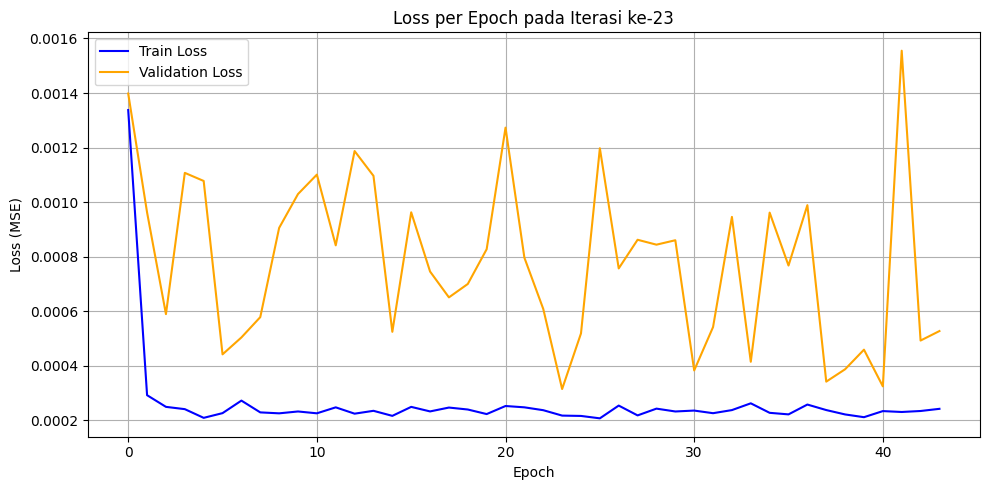

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.659481   0.664606   0.651903   0.655559   0.657776   0.654095   
2021-11-25   0.660594   0.665441   0.652774   0.656529   0.658594   0.655066   
2021-11-26   0.658722   0.664779   0.651756   0.655096   0.657883   0.653701   
2021-11-27   0.656767   0.663084   0.650089   0.653332   0.656242   0.651912   
2021-11-28   0.652292   0.659698   0.646569   0.649425   0.652928   0.647997   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.898708   0.910284   0.881362   0.882194   0.895261   0.885457   
2024-04-26   0.907864   0.912646   0.885171   0.889587   0.898137   0.892494   
2024-04-27   0.913668   0.918660   0.890721   0.895010   0.904086   0.898040   
2024-04-28   0.919427   0.924476   0.896173   0.900424   0.909857   0.903560   
2024-04-29   0.924976   0.930127   0.901442   0.905631   0.915458   0.908873   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_JPN.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_JPN.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_JPN.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnrs_JPN.csv')
#bm_train_predictions.to_csv('hasilprediksicnnrs_train_JPN.csv')
#bm_val_predictions.to_csv('hasilprediksicnnrs_val_JPN.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnrs_JPN.csv')
bm_train_predictions.to_csv('hasilprediksicnnrs_train_JPN.csv')
bm_val_predictions.to_csv('hasilprediksicnnrs_val_JPN.csv')


In [ ]:
!zip -r cnnrs_weights.zip /content/cnnrs_weights
from google.colab import files
files.download("cnnrs_weights.zip")

  adding: content/cnnrs_weights/ (stored 0%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_16.weights.h5 (deflated 51%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_2.weights.h5 (deflated 52%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_18.weights.h5 (deflated 53%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_27.weights.h5 (deflated 54%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_13.weights.h5 (deflated 53%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_22.weights.h5 (deflated 52%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_26.weights.h5 (deflated 52%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_12.weights.h5 (deflated 55%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_19.weights.h5 (deflated 53%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_30.weights.h5 (deflated 53%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_28.weights.h5 (deflated 54%)
  adding: content/cnn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

290.4444274179619 154691.82735264642 393.30881931714475 600098104057387.8
497.4481058206644 405552.0864035075 636.8297153898422 0.02969415405693751
555.7599965688357 472249.86411729833 687.2043830748596 0.023793059603733718


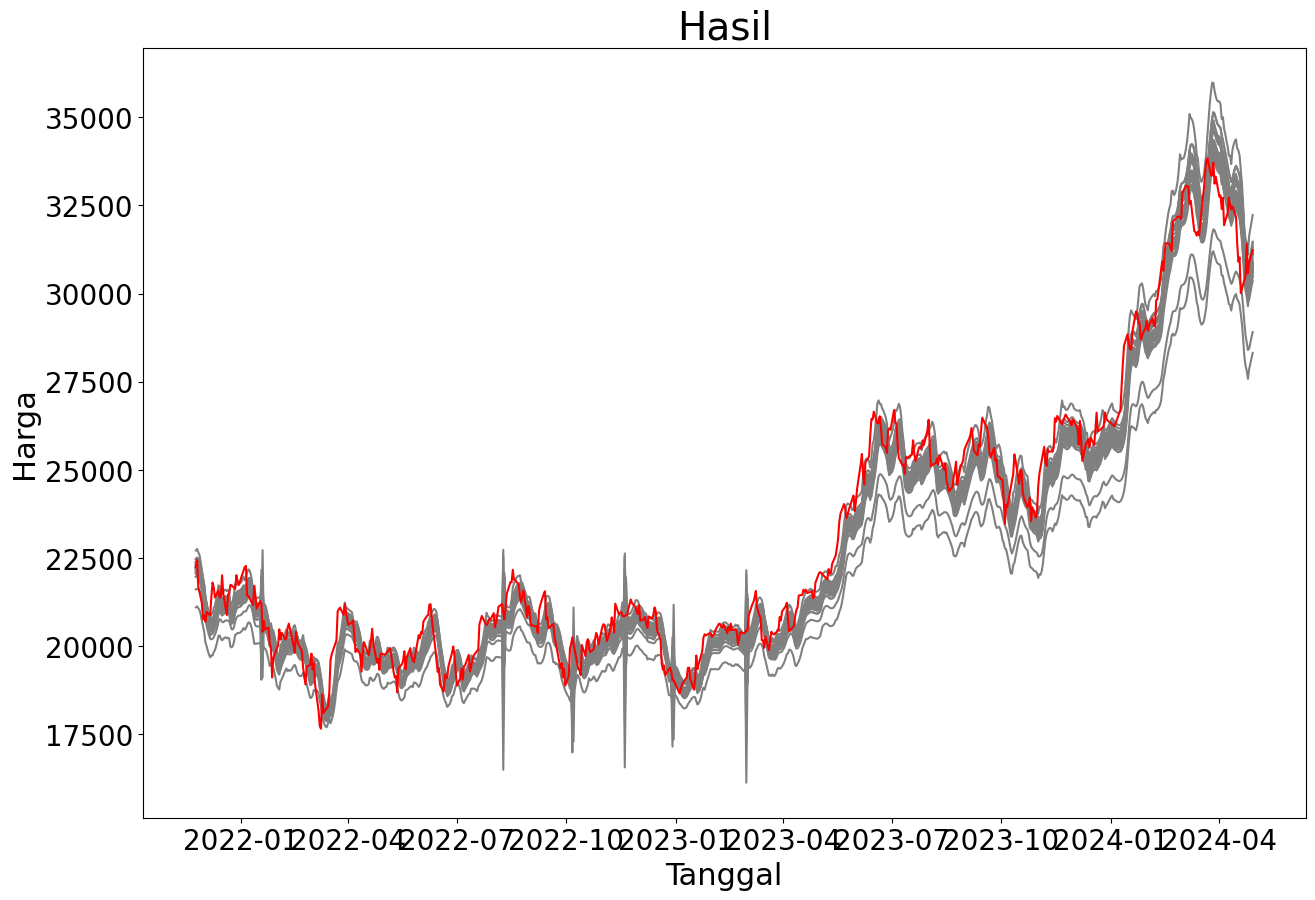

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

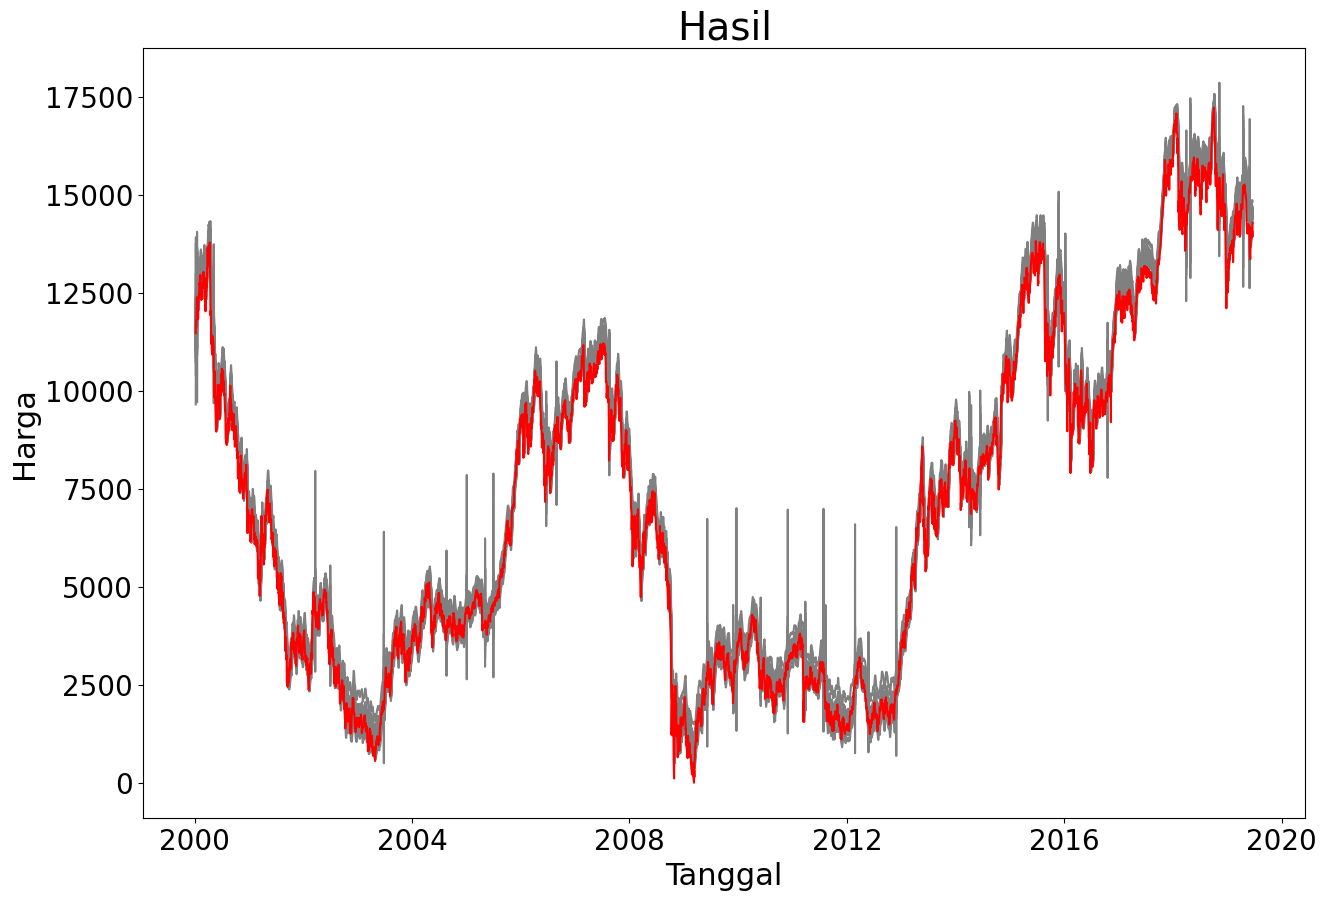

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## CNN dengan Bayesian

In [ ]:
X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mqn_80], X_pred[:Mqn_80], y_pred[:Mqn_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mqn_80:Mqn_90],  X_pred[Mqn_80:Mqn_90], y_pred[Mqn_80:Mqn_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mqn_90:],  X_pred[Mqn_90:], y_pred[Mqn_90:]
print(X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape)
print(y_pred_train.shape, y_pred_val.shape, y_pred_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(64, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(128, activation="tanh"))
cnn.add(Dropout(0.3))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnbo_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-8 dengan MAPE = 0.0248


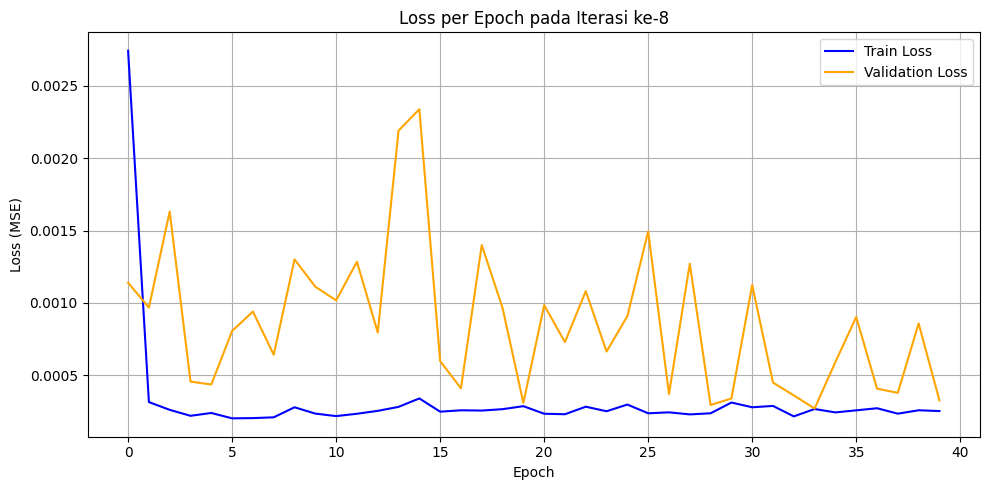

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.669044   0.663401   0.664541   0.653309   0.654908   0.659168   
2021-11-25   0.669928   0.664433   0.665694   0.654123   0.655706   0.660037   
2021-11-26   0.669165   0.663006   0.663783   0.653278   0.655118   0.659177   
2021-11-27   0.667374   0.661098   0.661750   0.651687   0.653497   0.657466   
2021-11-28   0.663690   0.656935   0.657116   0.648392   0.650282   0.653956   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.925832   0.911609   0.912733   0.875404   0.897103   0.902478   
2024-04-26   0.928895   0.918751   0.922849   0.879015   0.899088   0.906100   
2024-04-27   0.935227   0.924682   0.928705   0.884388   0.905023   0.912038   
2024-04-28   0.941367   0.930568   0.934627   0.889630   0.910749   0.917819   
2024-04-29   0.947322   0.936234   0.940299   0.894705   0.916313   0.923420   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_JPN.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_JPN.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_JPN.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

bm_prediction_df.to_csv('hasilprediksicnnbo_JPN.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_JPN.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_JPN.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnbo_JPN.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_JPN.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_JPN.csv')


In [ ]:
!zip -r cnnbo_weights.zip /content/cnnbo_weights
from google.colab import files
files.download("cnnbo_weights.zip")

  adding: content/cnnbo_weights/ (stored 0%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_16.weights.h5 (deflated 21%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_2.weights.h5 (deflated 20%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_18.weights.h5 (deflated 20%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_27.weights.h5 (deflated 21%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_13.weights.h5 (deflated 20%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_22.weights.h5 (deflated 19%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_26.weights.h5 (deflated 20%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_12.weights.h5 (deflated 20%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_19.weights.h5 (deflated 18%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_30.weights.h5 (deflated 20%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_28.weights.h5 (deflated 18%)
  adding: content/cnn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

275.04461816721016 130567.92432381386 361.3418386013635 306943990053846.25
439.11261547191725 342133.74315141013 584.9219974931787 0.02634491324414839
503.3693858653583 435227.02114924433 659.7173797538188 0.02155306858470023


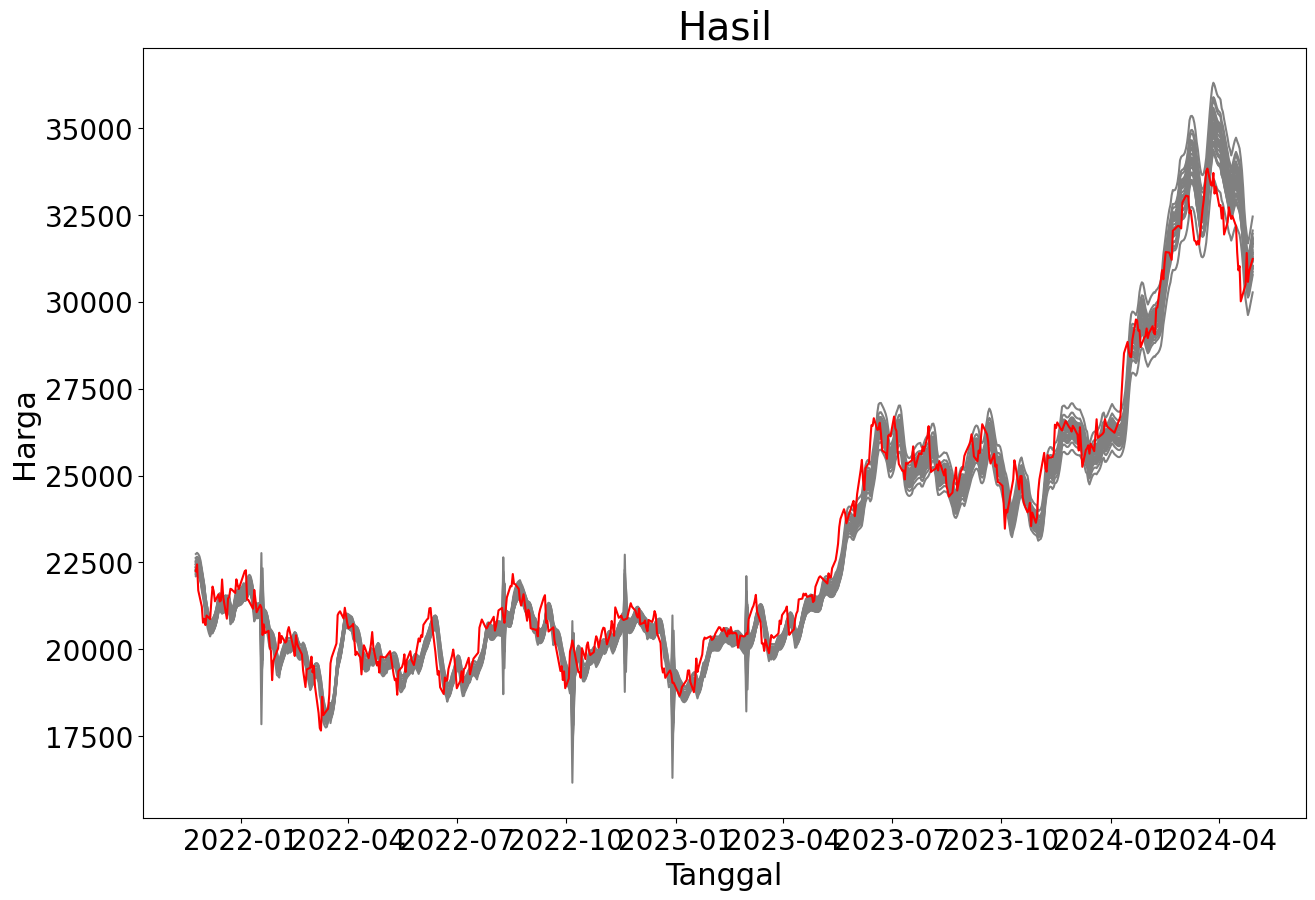

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

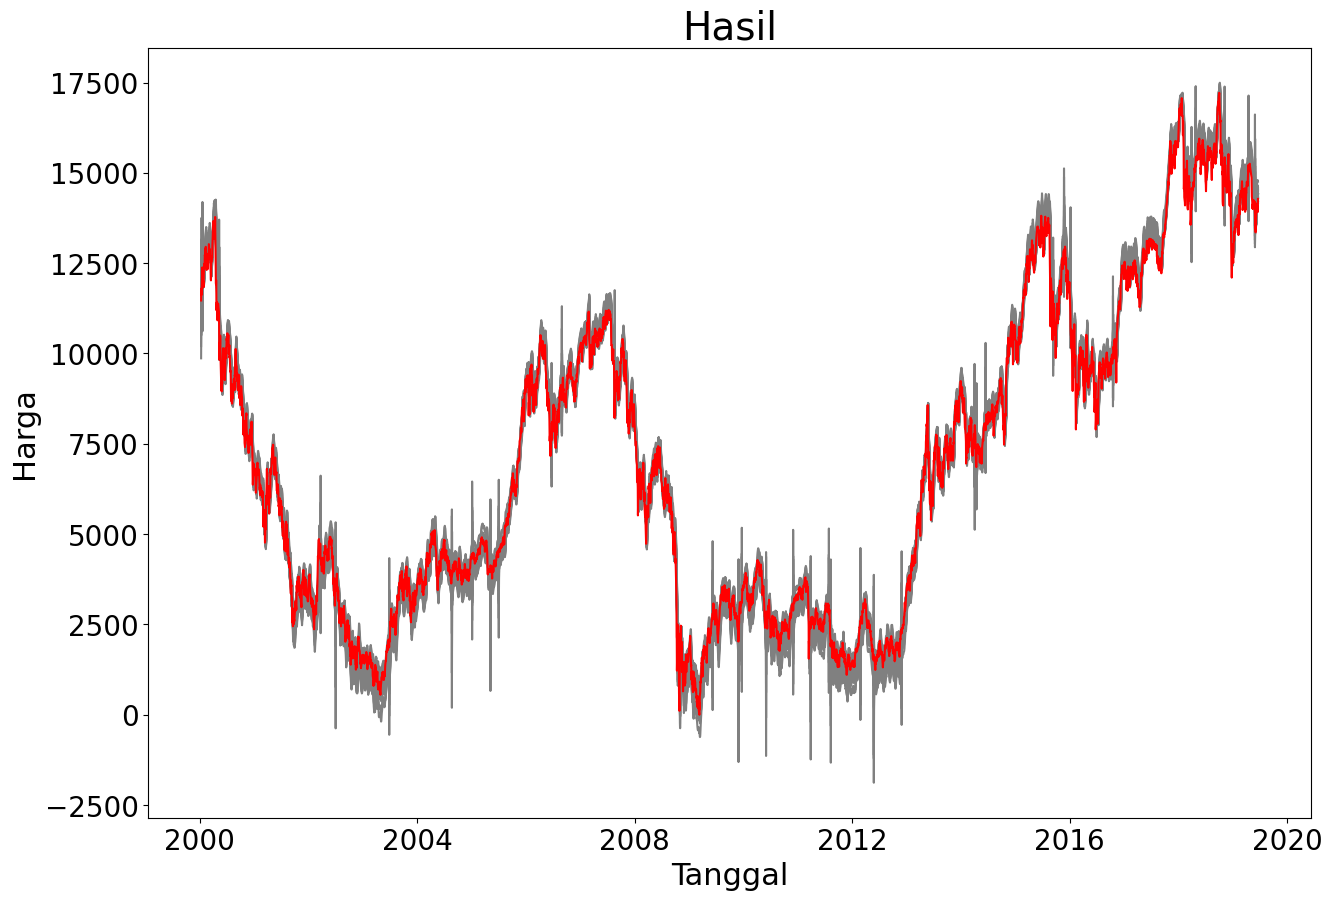

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2,2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_ann',
    project_name='ann_tuning'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Dense Layer 1 Units: {best_hps.get('dense_units_1')}
- Activation 1: {best_hps.get('activation_1')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 01m 13s]
val_loss: 0.0012745093554258347

Best val_loss So Far: 0.00027986677014268935
Total elapsed time: 00h 59m 33s

Best Hyperparameters:
- Dense Layer 1 Units: 32
- Activation 1: sigmoid
- Dropout: 0.3
- Learning Rate: 0.01



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp
def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2, 2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_ann_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_ann_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 00m 41s]
val_loss: 0.0005382322706282139

Best val_loss So Far: 0.0002605800109449774
Total elapsed time: 00h 57m 13s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
dense_units_1: 128
activation_1: sigmoid
dropout: 0.3
learning_rate: 0.01


In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(32, activation='sigmoid'))
ann.add(Dropout(0.3))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annrs_weights/best_annrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-1 dengan MAPE = 0.0433


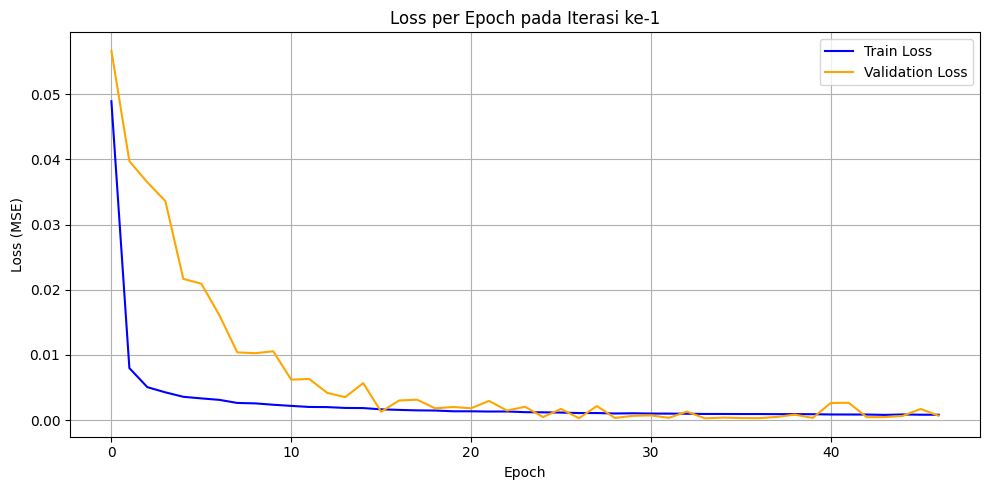

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.665172   0.656817   0.664503   0.657340   0.672375   0.661085   
2021-11-25   0.665732   0.657307   0.665134   0.657856   0.672943   0.661659   
2021-11-26   0.665594   0.657202   0.664959   0.657727   0.672796   0.661534   
2021-11-27   0.664359   0.656117   0.663576   0.656592   0.671547   0.660266   
2021-11-28   0.662043   0.654090   0.660980   0.654463   0.669201   0.657900   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.777364   0.753477   0.798549   0.758195   0.781489   0.779649   
2024-04-26   0.777202   0.753296   0.798398   0.758082   0.781386   0.779452   
2024-04-27   0.778521   0.754445   0.800082   0.759249   0.782576   0.780902   
2024-04-28   0.779736   0.755504   0.801635   0.760324   0.783669   0.782238   
2024-04-29   0.780886   0.756510   0.803106   0.761342   0.784701   0.783506   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_JPN.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_JPN.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_JPN.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_JPN.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_JPN.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_JPN.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannrs_JPN.csv')
bm_train_predictions.to_csv('hasilprediksiannrs_train_JPN.csv')
bm_val_predictions.to_csv('hasilprediksiannrs_val_JPN.csv')


In [ ]:
!zip -r annrs_weights.zip /content/annrs_weights
from google.colab import files
files.download("annrs_weights.zip")

  adding: content/annrs_weights/ (stored 0%)
  adding: content/annrs_weights/best_annrs_weights_iter_1.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_16.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_3.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_29.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_11.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_12.weights.h5 (deflated 85%)
  adding: content/annrs_weights/best_annrs_weights_iter_26.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_28.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_27.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_7.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_23.weights.h5 (deflated 86%)
  adding: content/annrs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

348.61346858432915 189667.28480420384 435.5080766233892 261972211173219.78
395.4691265484235 304564.38815750735 551.8735255087956 0.024117820814685418
1133.8528326910903 3523358.375219278 1877.0611005556739 0.04257662646167615


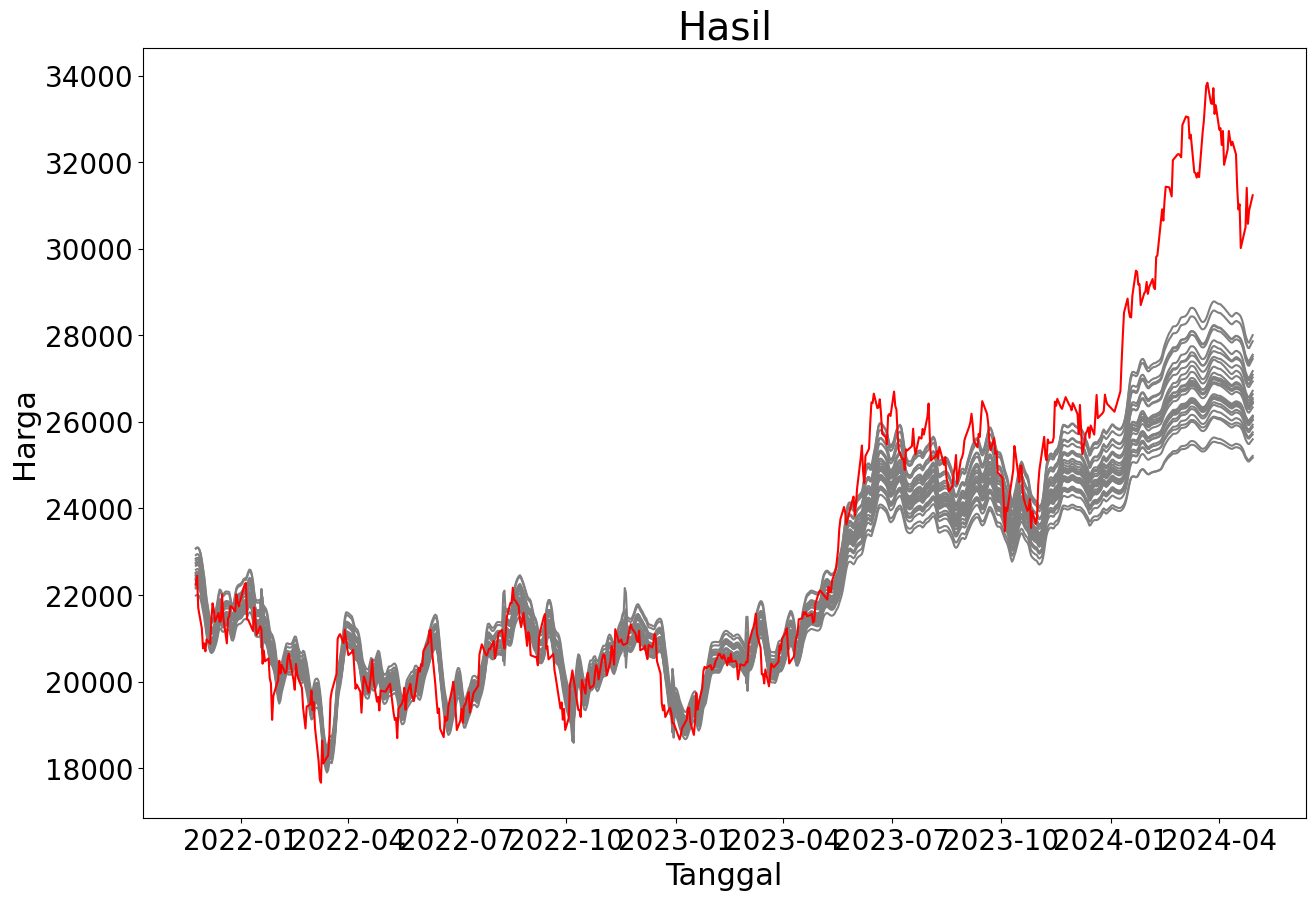

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

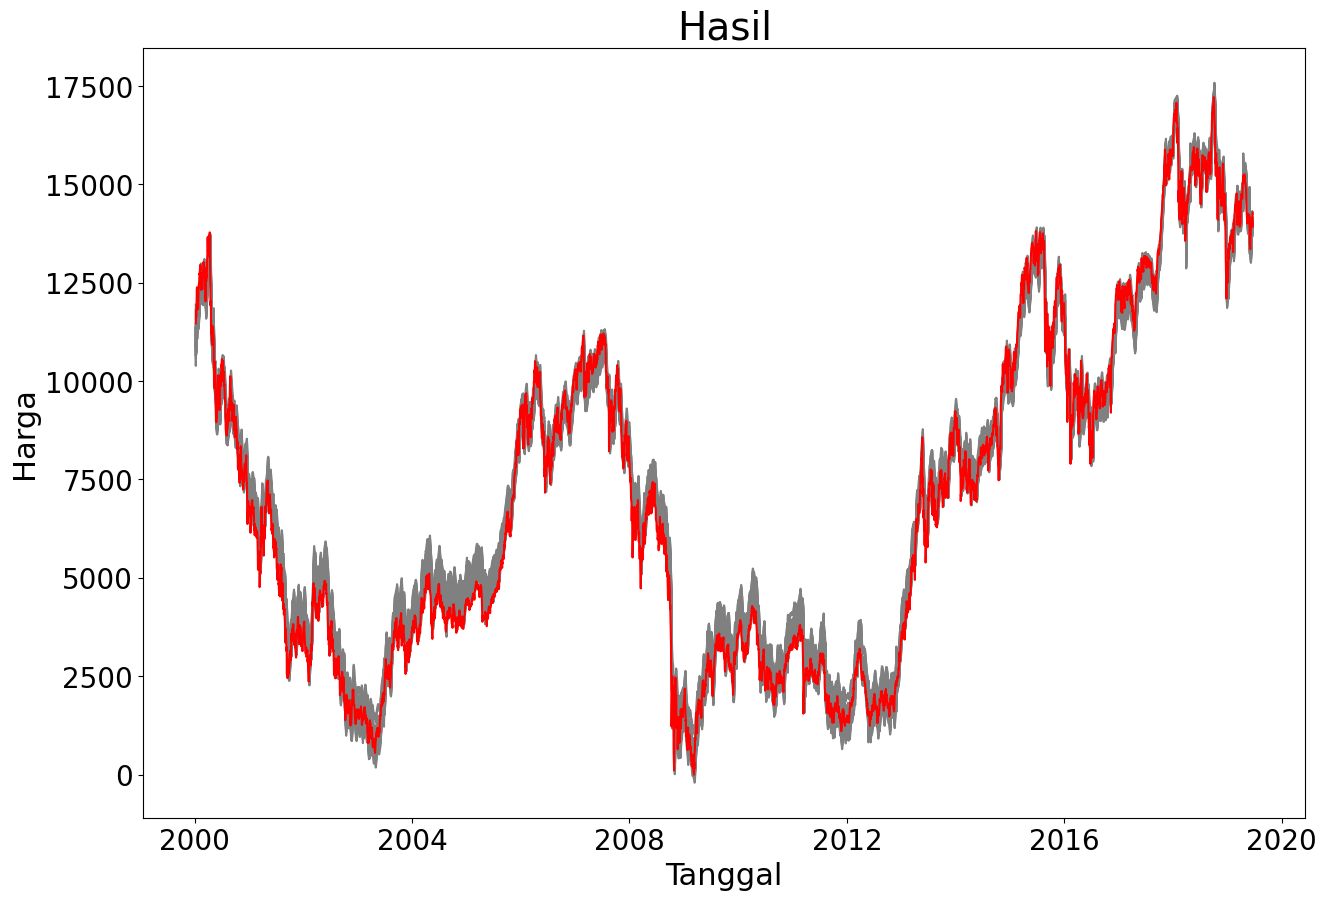

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN dengan Bayesian

In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(128, activation='sigmoid'))
ann.add(Dropout(0.3))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annbo_weights/best_annbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-27 dengan MAPE = 0.0295


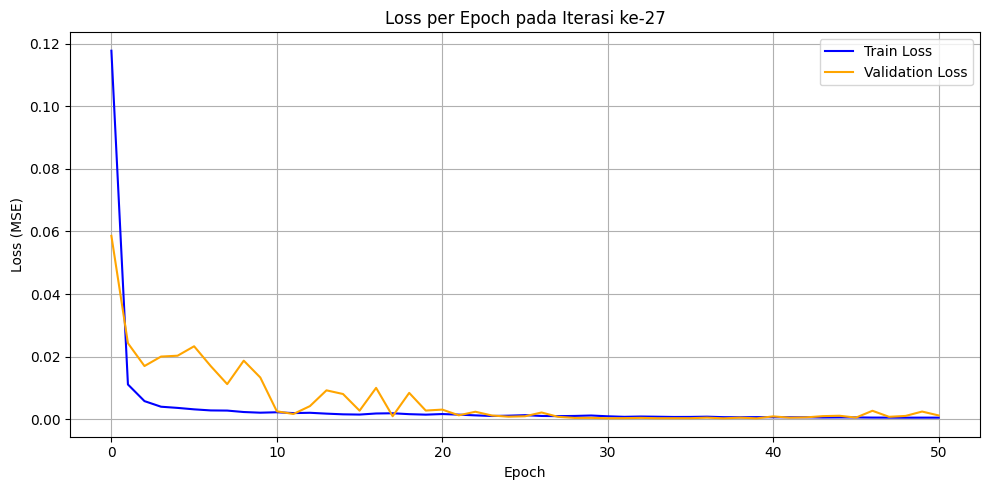

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.660836   0.670110   0.659850   0.666361   0.665893   0.666084   
2021-11-25   0.661481   0.670853   0.660444   0.667070   0.666585   0.666750   
2021-11-26   0.661335   0.670671   0.660303   0.666904   0.666420   0.666582   
2021-11-27   0.659910   0.669037   0.658992   0.665341   0.664897   0.665119   
2021-11-28   0.657256   0.665992   0.656544   0.662432   0.662059   0.662386   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.808716   0.854851   0.792265   0.846035   0.829185   0.821348   
2024-04-26   0.808428   0.854509   0.792036   0.845682   0.828888   0.821091   
2024-04-27   0.810485   0.857265   0.793844   0.848465   0.831151   0.823273   
2024-04-28   0.812388   0.859818   0.795517   0.851048   0.833241   0.825292   
2024-04-29   0.814200   0.862249   0.797110   0.853513   0.835225   0.827214   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_JPN.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_JPN.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_JPN.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_JPN.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_JPN.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_JPN.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannbo_JPN.csv')
bm_train_predictions.to_csv('hasilprediksiannbo_train_JPN.csv')
bm_val_predictions.to_csv('hasilprediksiannbo_val_JPN.csv')


In [ ]:
!zip -r annbo_weights.zip /content/annbo_weights
from google.colab import files
files.download("annbo_weights.zip")

  adding: content/annbo_weights/ (stored 0%)
  adding: content/annbo_weights/best_annbo_weights_iter_20.weights.h5 (deflated 67%)
  adding: content/annbo_weights/best_annbo_weights_iter_29.weights.h5 (deflated 67%)
  adding: content/annbo_weights/best_annbo_weights_iter_8.weights.h5 (deflated 67%)
  adding: content/annbo_weights/best_annbo_weights_iter_17.weights.h5 (deflated 67%)
  adding: content/annbo_weights/best_annbo_weights_iter_19.weights.h5 (deflated 67%)
  adding: content/annbo_weights/best_annbo_weights_iter_5.weights.h5 (deflated 67%)
  adding: content/annbo_weights/best_annbo_weights_iter_24.weights.h5 (deflated 67%)
  adding: content/annbo_weights/best_annbo_weights_iter_27.weights.h5 (deflated 67%)
  adding: content/annbo_weights/best_annbo_weights_iter_14.weights.h5 (deflated 67%)
  adding: content/annbo_weights/best_annbo_weights_iter_18.weights.h5 (deflated 68%)
  adding: content/annbo_weights/best_annbo_weights_iter_22.weights.h5 (deflated 67%)
  adding: content/annb

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

301.520586623324 155569.53296643094 394.42303807768496 373612719690518.1
382.5016871363554 295606.62121205847 543.6971778591999 0.023134978687615926
734.7632708391994 1304025.5558897806 1141.9393836319775 0.028764343903326363


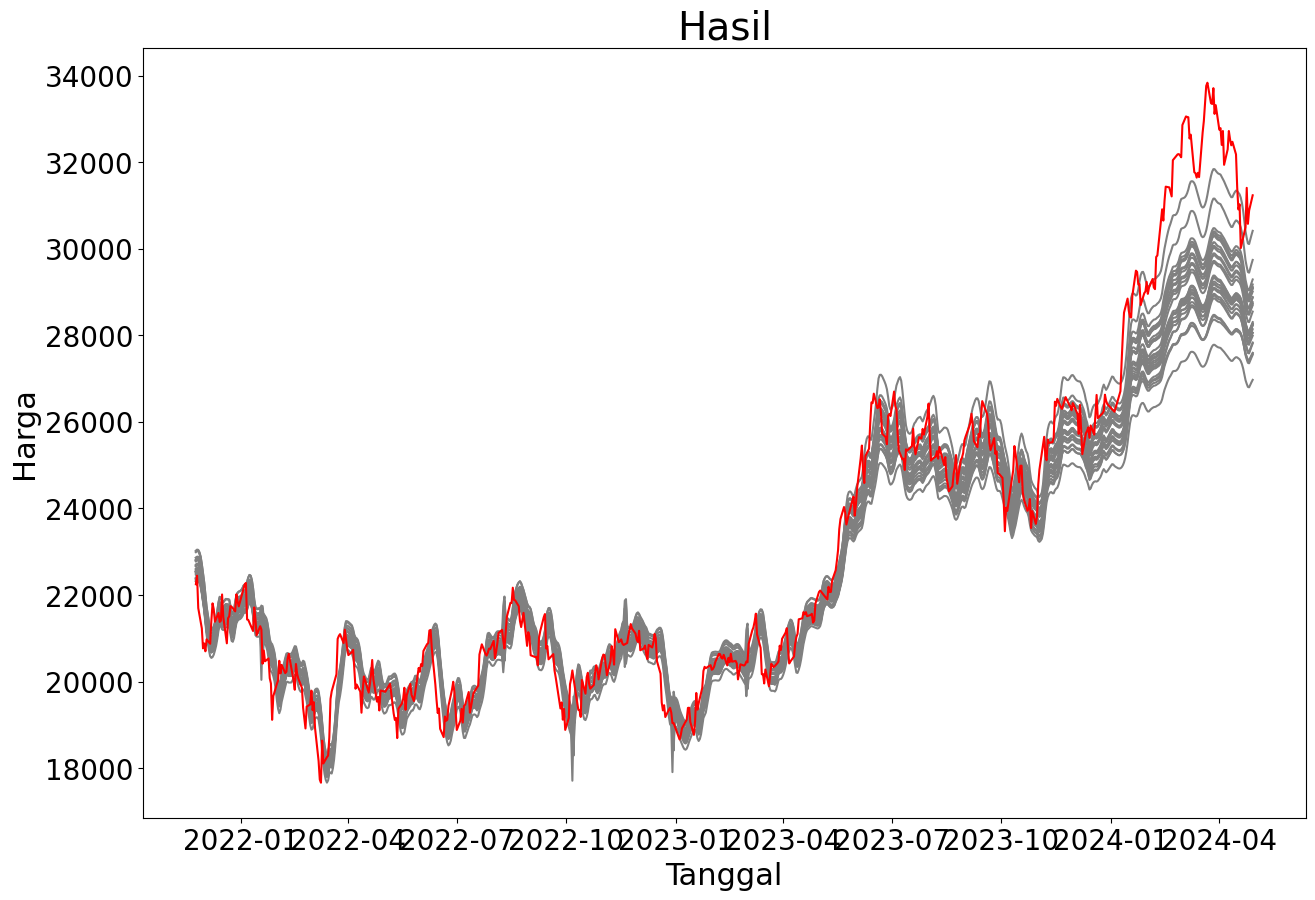

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

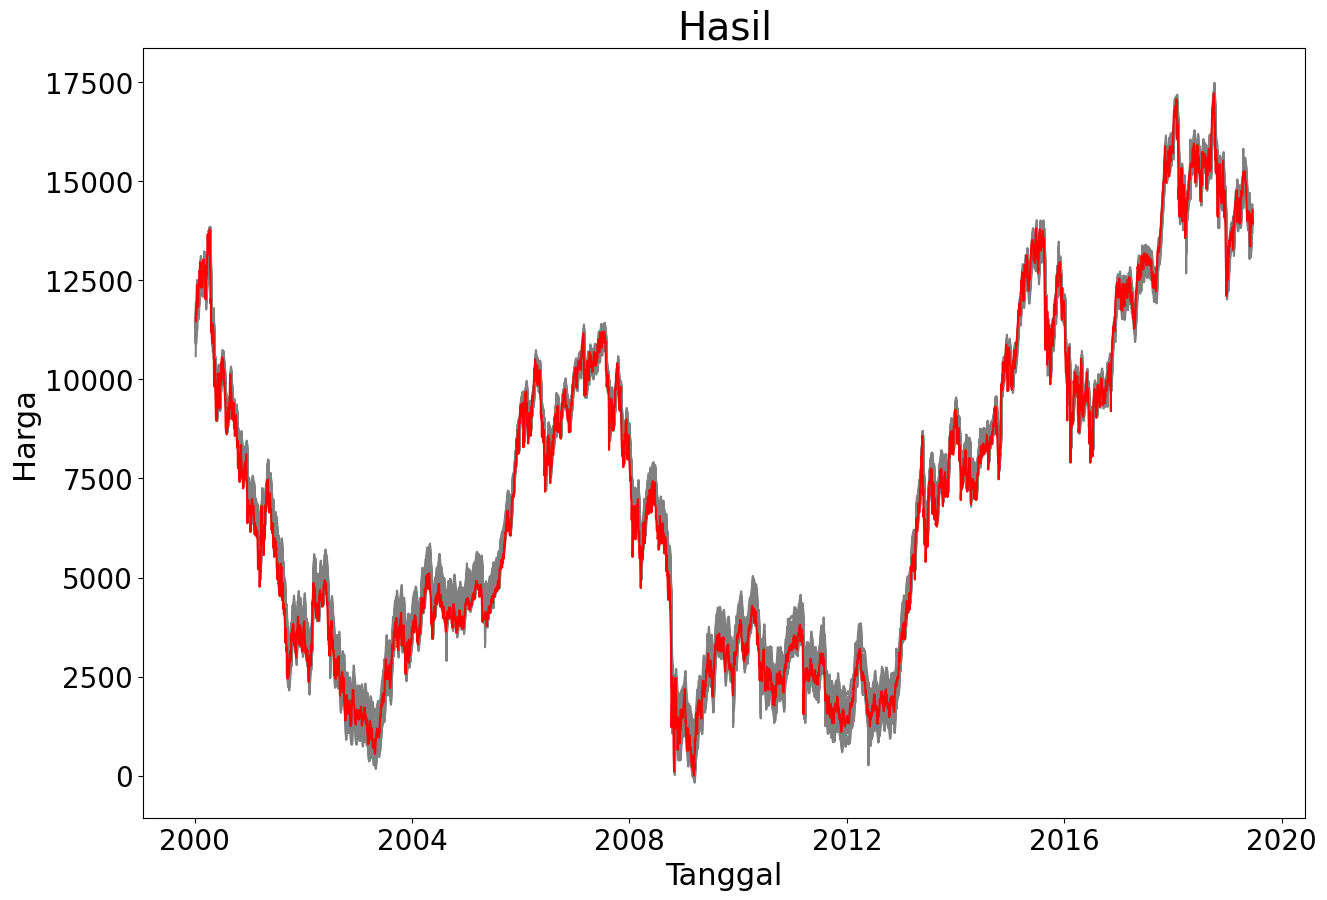

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import SimpleRNN
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_rnn',
    project_name='rnn_tuning'
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- RNN Units: {best_hps.get('rnn_units')}
- Activation: {best_hps.get('activation')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 00m 43s]
val_loss: 0.00041571282781660557

Best val_loss So Far: 0.0002772344450931996
Total elapsed time: 01h 11m 26s

Best Hyperparameters:
- RNN Units: 8
- Activation: sigmoid
- Dropout: 0.2
- Learning Rate: 0.01



In [ ]:
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
best_rnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_rnn_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 01m 02s]
val_loss: 0.0005927897873334587

Best val_loss So Far: 0.0002752389991655946
Total elapsed time: 01h 05m 42s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
rnn_units: 64
activation: sigmoid
dropout: 0.1
learning_rate: 0.001


In [ ]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
rnn = Sequential()
rnn.add(SimpleRNN(8, activation='sigmoid', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.2))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnrs_weights/best_rnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━


 Model di iterasi ke-13 dengan MAPE = 0.0382


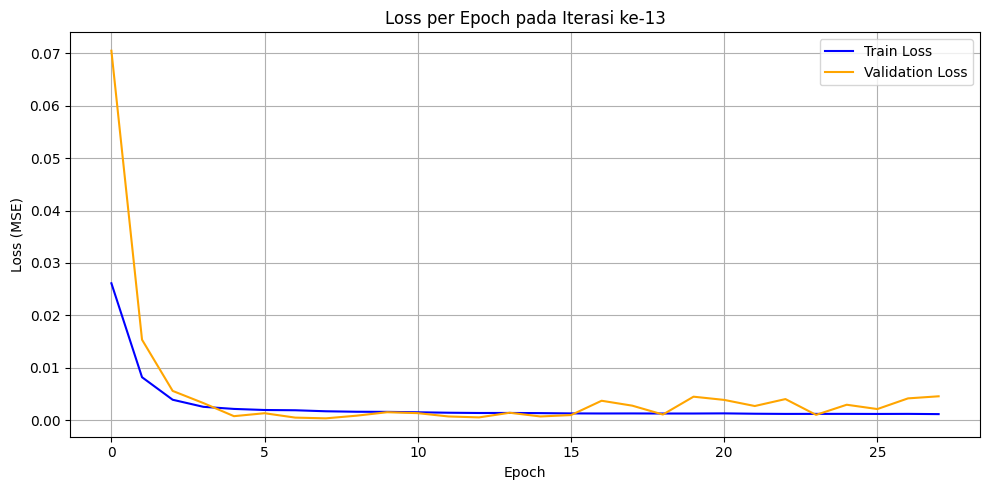

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.608229   0.620199   0.640450   0.598755   0.605427   0.613526   
2021-11-25   0.608834   0.620812   0.641088   0.599279   0.605929   0.613994   
2021-11-26   0.608374   0.620226   0.640673   0.598853   0.605584   0.613650   
2021-11-27   0.607138   0.619012   0.639349   0.597794   0.604548   0.612690   
2021-11-28   0.604668   0.616523   0.636747   0.595667   0.602491   0.610778   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.738626   0.761815   0.791034   0.729219   0.707336   0.712496   
2024-04-26   0.739921   0.764726   0.792914   0.731339   0.708135   0.713840   
2024-04-27   0.741993   0.767505   0.795571   0.733988   0.709662   0.715435   
2024-04-28   0.743971   0.770225   0.798128   0.736561   0.711116   0.716974   
2024-04-29   0.745852   0.772827   0.800570   0.739030   0.712500   0.718437   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_JPN.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_JPN.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_JPN.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_JPN.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_JPN.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_JPN.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnrs_JPN.csv')
bm_train_predictions.to_csv('hasilprediksirnnrs_train_JPN.csv')
bm_val_predictions.to_csv('hasilprediksirnnrs_val_JPN.csv')


In [ ]:
!zip -r rnnrs_weights.zip /content/rnnrs_weights
from google.colab import files
files.download("rnnrs_weights.zip")

  adding: content/rnnrs_weights/ (stored 0%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_20.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_29.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_12.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_16.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_3.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_9.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_10.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_17.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_25.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_1.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_23.weights.h5 (deflated 89%)
  adding: content/rnnrs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

502.2382982687342 338216.4362340515 581.5637851809993 917683956283576.0
1044.7975766293655 1679498.1693438264 1295.954539844599 0.05502248885030779
2552.4059904631213 10055732.932538694 3171.0775664651746 0.10164303453723832


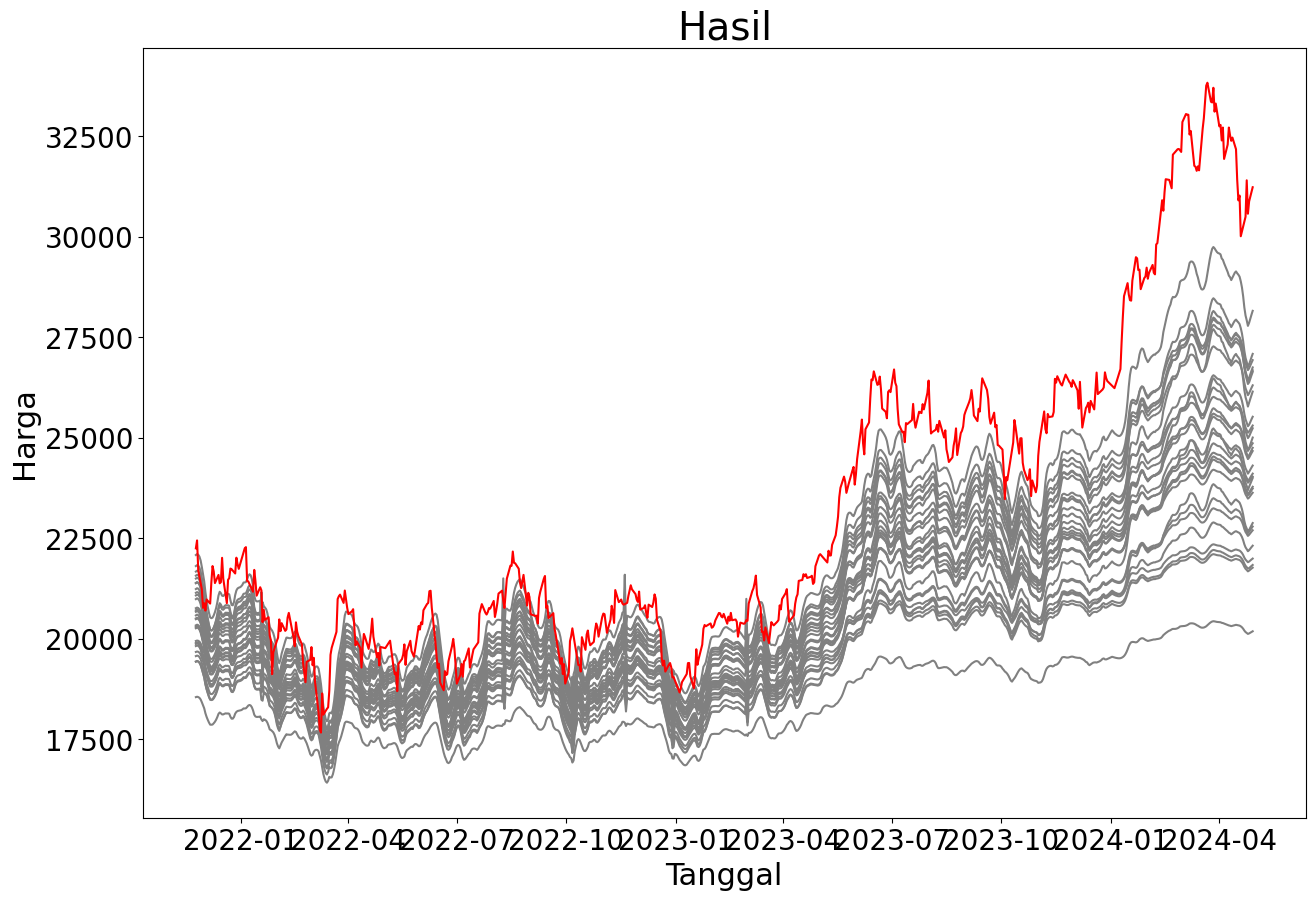

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

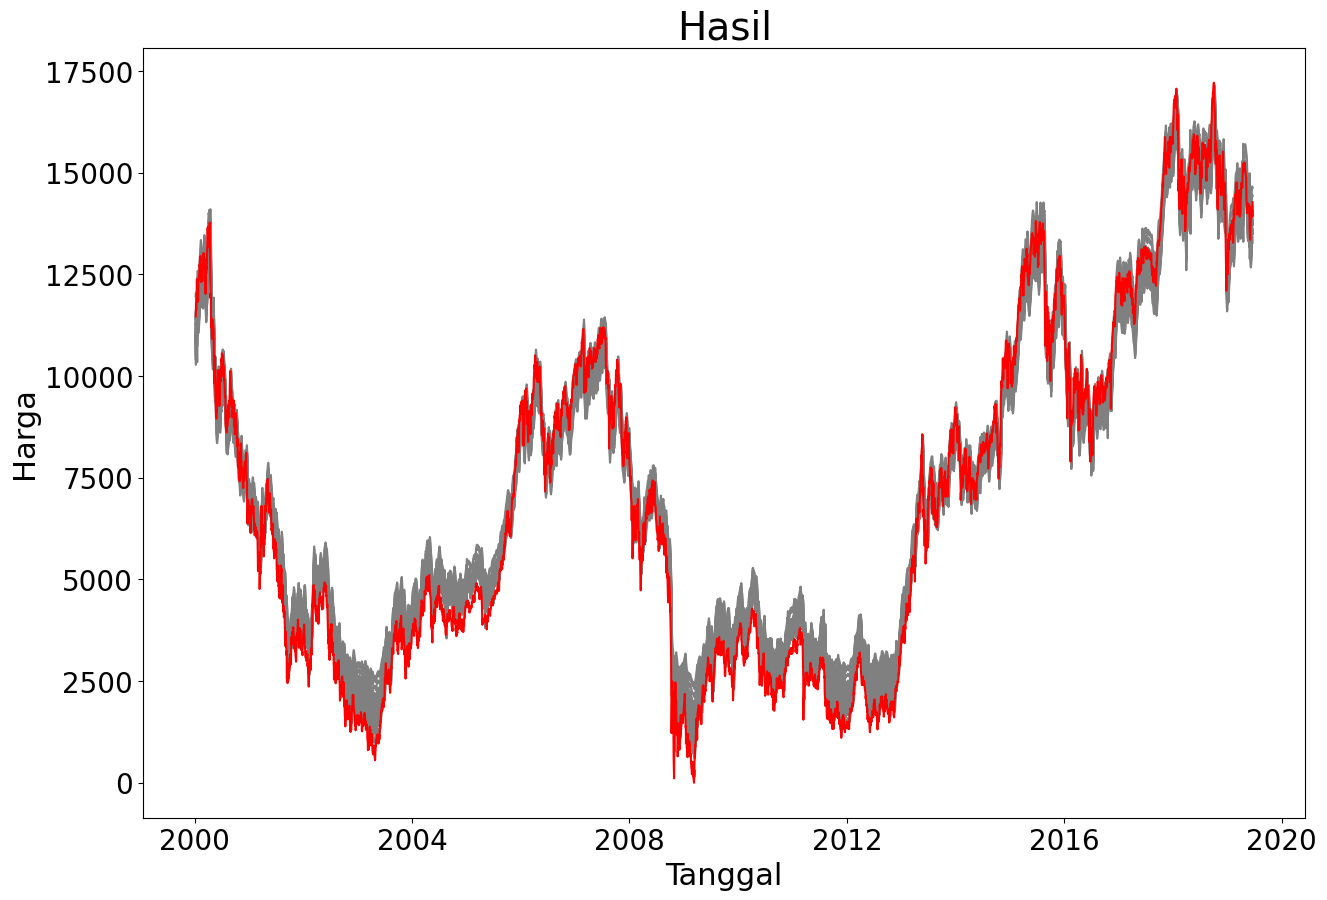

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN dengan Bayesian

In [ ]:
from tensorflow.keras.layers import SimpleRNN
rnn = Sequential()
rnn.add(SimpleRNN(64, activation='sigmoid', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.1))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnbo_weights/best_rnnbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 


 Model di iterasi ke-18 dengan MAPE = 0.0264


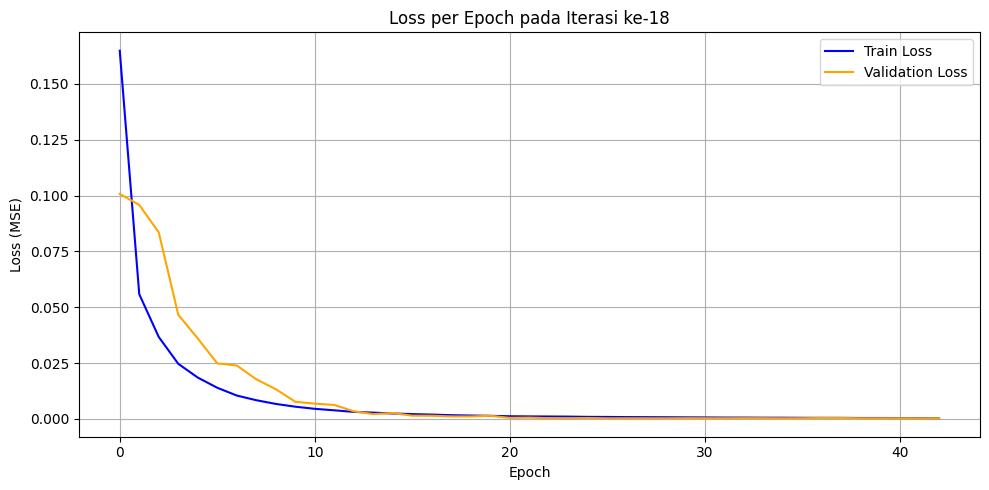

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")

best_history = bm_histories[best_iter]

plt.figure(figsize=(10, 5))
plt.plot(best_history['loss'], label='Train Loss', color='blue')
plt.plot(best_history['val_loss'], label='Validation Loss', color='orange')
plt.title(f'Loss per Epoch pada Iterasi ke-{best_iter+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.672268   0.674408   0.668009   0.671806   0.669053   0.671172   
2021-11-25   0.673050   0.675209   0.668781   0.672573   0.669811   0.671946   
2021-11-26   0.673025   0.675071   0.668666   0.672537   0.669814   0.671887   
2021-11-27   0.671257   0.673293   0.666947   0.670804   0.668091   0.670146   
2021-11-28   0.668067   0.670026   0.663800   0.667671   0.664998   0.666986   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.961437   0.961822   0.943776   0.958912   0.961369   0.956276   
2024-04-26   0.960390   0.961340   0.943422   0.957570   0.960123   0.955090   
2024-04-27   0.967497   0.968432   0.950220   0.964761   0.967593   0.962160   
2024-04-28   0.974238   0.975178   0.956692   0.971577   0.974685   0.968864   
2024-04-29   0.980815   0.981756   0.963004   0.978237   0.981618   0.975409   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_JPN.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_JPN.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_JPN.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_JPN.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_JPN.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_JPN.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnbo_JPN.csv')
bm_train_predictions.to_csv('hasilprediksirnnbo_train_JPN.csv')
bm_val_predictions.to_csv('hasilprediksirnnbo_val_JPN.csv')


In [ ]:
!zip -r rnnbo_weights.zip /content/rnnbo_weights
from google.colab import files
files.download("rnnbo_weights.zip")

  adding: content/rnnbo_weights/ (stored 0%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_4.weights.h5 (deflated 33%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_27.weights.h5 (deflated 34%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_7.weights.h5 (deflated 33%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_24.weights.h5 (deflated 33%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_29.weights.h5 (deflated 34%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_21.weights.h5 (deflated 33%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_30.weights.h5 (deflated 33%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_20.weights.h5 (deflated 33%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_3.weights.h5 (deflated 33%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_23.weights.h5 (deflated 33%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_25.weights.h5 (deflated 33%)
  adding: content/rnnbo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

279.56647404403196 134085.58466937323 366.1769854447071 748357230391294.9
396.4496811508776 317623.0871892289 563.5805951141584 0.02386240250209918
714.0539209864158 1124633.4072549324 1060.4873442219537 0.02858224424124297


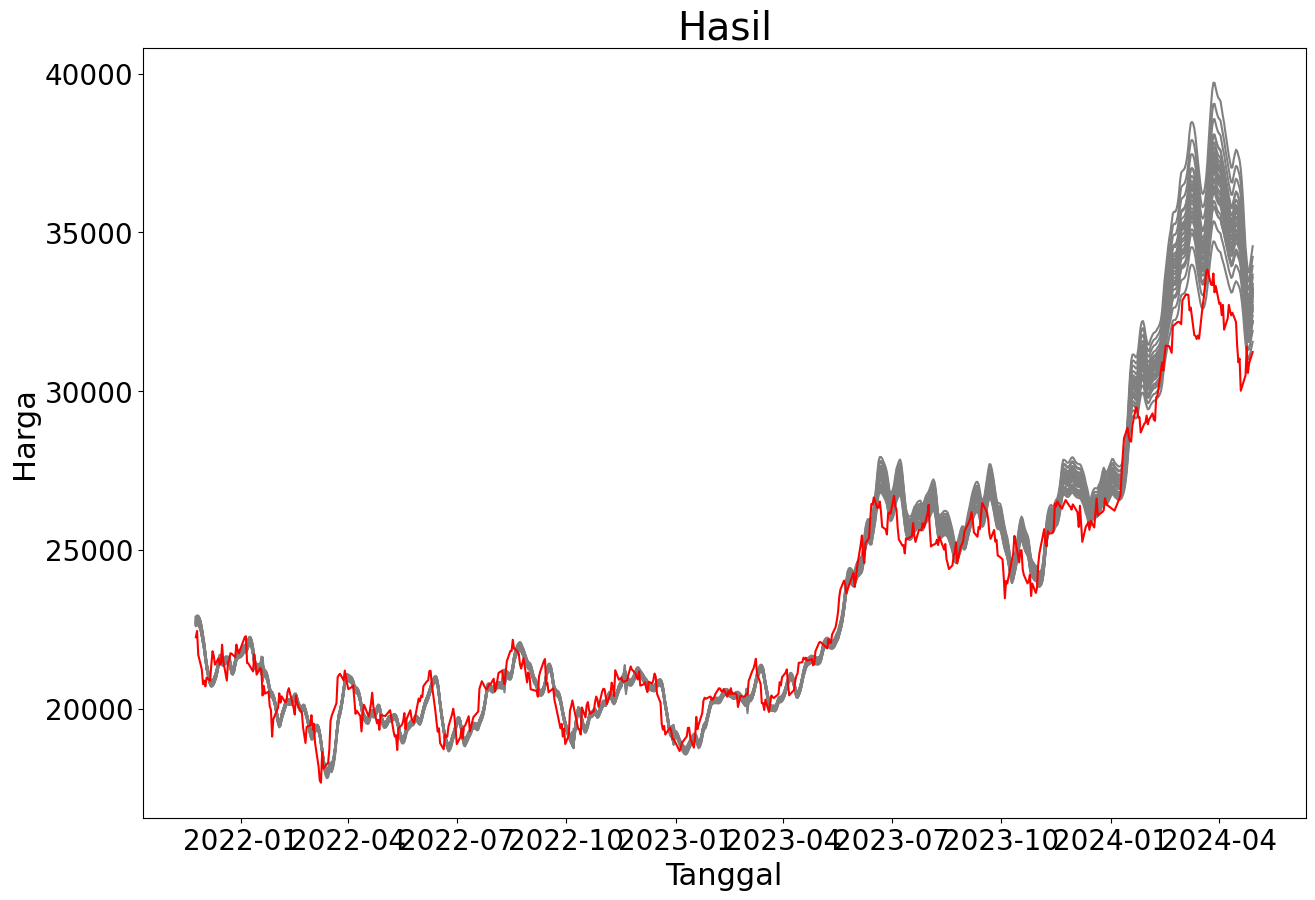

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

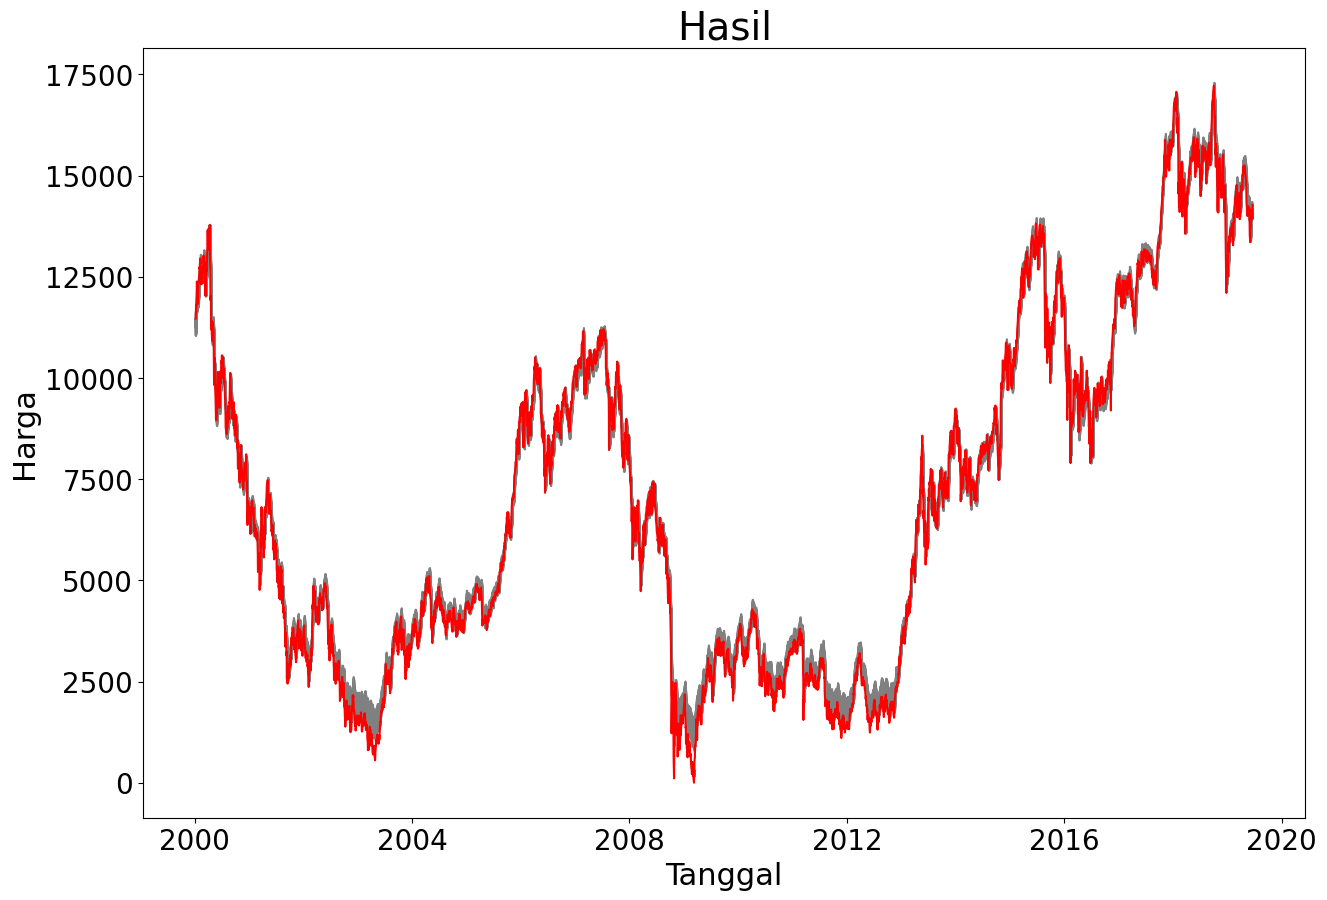

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## LSTM dengan Input Harga Saham dan Keputusan Jual Beli

In [ ]:
datacopy = data_full[3:]
datacopy

In [ ]:
datacopy['EMA_50'] = datacopy['Close'].ewm(span=50, adjust=False).mean()
datacopy['EMA_200'] = datacopy['Close'].ewm(span=200, adjust=False).mean()
datacopy['Diff']= datacopy['EMA_50']-datacopy['EMA_200']
datacopy['sign'] = datacopy['Diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
datacopy['sign_change'] = datacopy['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
filter = datacopy[datacopy['sign_change'] == 1]
idx_datafull = filter.index
datacopy['label'] = np.where(
    (datacopy['sign'] == 1) & (datacopy['sign_change'] != 0), 'Sell',
    np.where((datacopy['sign'] == -1) & (datacopy['sign_change'] != 0), 'Buy', 'Keep')
)
check = datacopy[datacopy['sign_change'] != 0]
check

In [ ]:
datacopy['label1'] = datacopy['label'].apply(lambda x: -1 if x == 'Sell' else (1 if x == 'Buy' else 0))
datacopy
check = datacopy[datacopy['label1'] != 0]
check

In [ ]:
#data_full['Close'] = pd.to_numeric(datacopy['Close'])
#datacopy['label1'] = pd.to_numeric(datacopy['label1'])

X_actual, y_actual, dates_actual = windowed_df_close(datacopy[['Close','label1']],2)
banyakn = len(X_actual)
Mq_80 = int(banyakn * .8)
Mq_90 = int(banyakn * .9)
dates_actual_train, X_actual_train, y_actual_train = dates_actual[:Mq_80], X_actual[:Mq_80], y_actual[:Mq_80]
dates_actual_val, X_actual_val, y_actual_val = dates_actual[Mq_80:Mq_90], X_actual[Mq_80:Mq_90], y_actual[Mq_80:Mq_90]
dates_actual_test, X_actual_test, y_actual_test = dates_actual[Mq_90:], X_actual[Mq_90:], y_actual[Mq_90:]

In [ ]:
datacopy

In [ ]:
y_actual.shape

In [ ]:
from hyperopt import hp

space = {
    'hiddenLayerOne': hp.choice('hiddenLayerOne', [32, 64, 128]),
    'hiddenLayerTwo': hp.choice('hiddenLayerTwo', [32, 64, 128]),
    'activation': hp.choice('activation', ['tanh', 'relu']),
    'epochs': hp.choice('epochs',[50,100,150,200]),
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01]),
    'dropout': hp.choice('dropout', [0.1, 0.2, 0.3]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

def objective(params):
    model = Sequential([
        LSTM(params['hiddenLayerOne'], activation=params['activation'], return_sequences=True, input_shape=(2, 2)),
        Dropout(params['dropout']),
        LSTM(params['hiddenLayerTwo'], activation=params['activation']),
        Dropout(params['dropout']),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='mse',
                  metrics=['mean_absolute_error'])

    es = EarlyStopping(monitor='val_loss',mode='min',
                       verbose=1,patience=5)

    model.fit(X_actual_train, y_actual_train, batch_size=int(params['batch_size']),validation_data=(X_actual_val, y_actual_val))

    score, acc = model.evaluate(X_actual_val, y_actual_val, verbose=0)

    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params}

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
trials = Trials()

In [ ]:
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=175,
  trials=trials)

In [ ]:
space_eval(space, best_params)

In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (2,2)),
    layers.Dropout(0.2),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

RUN

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta = 0.0001,
    restore_best_weights=True
)

In [ ]:
result = []
mapes = []
prediction_result = []
histories = []

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    history = model.fit(X_actual_train, y_actual_train, batch_size=128, validation_data=(X_actual_val, y_actual_val), epochs=50)

    result.append(history)
    histories.append(history.history)

    predictions = model.predict(X_actual_test).flatten()
    mape = mean_absolute_percentage_error(y_actual_test, predictions)
    prediction_result.append(predictions)
    mapes.append(mape)
    print(f"Iteration {i+1}: MAPE = {mape}")

In [ ]:
import numpy as np

all_train_loss = np.array([h['loss'] for h in histories])
all_val_loss = np.array([h['val_loss'] for h in histories])

mean_train_loss = np.mean(all_train_loss, axis=0)
mean_val_loss = np.mean(all_val_loss, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_train_loss, label='Rata-rata Training Loss')
plt.plot(mean_val_loss, label='Rata-rata Validation Loss')
plt.title('Rata-rata Loss per Epoch dari 30 Iterasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
prediction_df = pd.DataFrame(prediction_result).transpose()
prediction_df.index = dates_actual_test
prediction_df.columns = [f'Iterasi {i+1}' for i in range(prediction_df.shape[1])]
print(prediction_df)

In [ ]:
prediction_df2 = prediction_df.copy(deep=True)
print(prediction_df2)

In [ ]:
prediction_df2 = prediction_df2.multiply(range_value)
print(prediction_df2)

In [ ]:
y_test2 = y_actual_test * range_value
y_test2

In [ ]:
prediction_df2['Rata2'] = prediction_df2.mean(axis=1)
print(prediction_df2)

In [ ]:
from math import sqrt
hasil = prediction_df2['Rata2']
close_test_mae = mean_absolute_error(y_test2, hasil)
close_test_mse = mean_squared_error(y_test2, hasil)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, hasil)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

In [ ]:
prediction_df2.to_csv('hasilprediksilstm2fit_INDO.csv')